# Notebook with a pipeline summary

We present our modular pipeline and the classification results.

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Imports 

import os
import spacy
from IPython.display import display 

from src.pipelinelib.querying import Parser, Queryable
from src.pipelinelib.text_body import TextBody
from src.pipelinelib.pipeline import Pipeline

from src.sigmund.preprocessing.words import Tokenizer, Stemmer, Lemmatizer
from src.sigmund.features.tfidf import FeatureTFIDF
from src.sigmund.features.liwc import Liwc
from src.sigmund.features.pos import PartOfSpeech
from src.sigmund.features.vocabulary_size import VocabularySize
from src.sigmund.classification.pca import PCAReduction
from src.sigmund.classification.naive_bayes import NaiveBayes
from src.sigmund.classification.merger import FeatureMerger
from src.sigmund.classification.linear_discriminant_analysis import LinearDiscriminantAnalysisClassifier
from src.sigmund.extensions import *

nlp = spacy.load("de_core_news_sm", disable=["ner", "parser"])

In [22]:
# Read data

folder = os.path.join(os.getcwd(), "data", "transcripts")
#files = [os.path.join(root, f) for root, _, files in os.walk(folder) for f in files if f.endswith(".docx")]

files = [
"data/transcripts/Paar 27_T1_IM_FW.docx",
"data/transcripts/Paar 182_T1_IM_FW.docx",
"data/transcripts/Paar 81_T1_IM_FW.docx",
"data/transcripts/Paar 47_T1_IM_FW.docx",
"data/transcripts/Paar 58_T1_IM_FW.docx",
"data/transcripts/Paar 29_T1_IM_FW.docx",
"data/transcripts/Paar 105_T1_IM_FW.docx",
"data/transcripts/Paar 60_T1_IM_FW.docx",
"data/transcripts/Paar 138_T1_IM_FW.docx",
"data/transcripts/Paar 87_T1_IM_FW.docx"]

parser = Parser(nlp=nlp, metadata_path="./data/transcripts/Kopie von Transkriptionspaare_Daten.xls")
parser.read_from_files(files)
queryable = Queryable.from_parser(parser)

=== Parser: reading from data/transcripts/Paar 27_T1_IM_FW.docx ===
=== Parser: reading from data/transcripts/Paar 182_T1_IM_FW.docx ===
=== Parser: reading from data/transcripts/Paar 81_T1_IM_FW.docx ===
=== Parser: reading from data/transcripts/Paar 47_T1_IM_FW.docx ===
=== Parser: reading from data/transcripts/Paar 58_T1_IM_FW.docx ===
=== Parser: reading from data/transcripts/Paar 29_T1_IM_FW.docx ===
=== Parser: reading from data/transcripts/Paar 105_T1_IM_FW.docx ===
=== Parser: reading from data/transcripts/Paar 60_T1_IM_FW.docx ===
=== Parser: reading from data/transcripts/Paar 138_T1_IM_FW.docx ===
=== Parser: reading from data/transcripts/Paar 87_T1_IM_FW.docx ===


# Pipeline with Voting-Classifier

=== Starting pipeline with ['Tokenizer', 'Stemmer', 'Lemmatizer', 'FeatureTFIDF', 'NaiveBayes for [tfidf_document_mf(feature)]', 'Liwc', 'NaiveBayes for [liwc_document_mf(feature)]', 'PartOfSpeech', 'NaiveBayes for [pos_document_mf(feature)]', 'NaiveBayes for [nb_class_tfidf(classifier), nb_class_liwc(classifier), nb_class_pos(classifier)]'] ===
Executing Tokenizer
Executing Stemmer
Executing Lemmatizer
Executing FeatureTFIDF
Executing NaiveBayes for [tfidf_document_mf(feature)]


,couple_id,is_depressed_group,ja,auch,wenn,also,werden,schon,wir,und,haben,du,sehr
0,27,True,0.285468,0.190312,0.158593,0.023789,0.047578,0.000000,0.174453,0.174453,0.055508,0.214101,0.019042
1,182,False,0.288880,0.151318,0.061903,0.020634,0.013756,0.022601,0.089415,0.192587,0.103171,0.185709,0.041292
2,81,False,0.119853,0.094430,0.065374,0.003632,0.018160,0.015912,0.152540,0.261497,0.170700,0.177964,0.000000
3,47,True,0.381989,0.238743,0.083560,0.071623,0.023874,0.026150,0.131309,0.202931,0.023874,0.131309,0.042998
4,58,False,0.107947,0.165519,0.028786,0.007196,0.043179,0.031529,0.158322,0.230287,0.143929,0.223090,0.146890
5,29,False,0.254254,0.095345,0.038138,0.076276,0.031782,0.069622,0.044494,0.228828,0.139839,0.209759,0.053423
6,105,True,0.242336,0.163933,0.099785,0.064148,0.064148,0.031227,0.121168,0.135423,0.171060,0.320738,0.000000
7,60,True,0.246445,0.164297,0.116377,0.027383,0.088994,0.157461,0.082148,0.150605,0.075303,0.253291,0.008219
8,138,True,0.438458,0.191825,0.054807,0.049326,0.016442,0.090046,0.147979,0.164422,0.043846,0.060288,0.052644
9,87,False,0.379430,0.178874,0.151772,0.032523,0.032523,0.035622,0.102988,0.130090,0.119249,0.352328,0.045557


'----------------------------------------'

'Prediction from one cross-validation'

,couple_id,is_depressed_group,predicted
0,27,1,1
1,182,0,1
2,81,0,0
3,47,1,1
4,58,0,0
5,29,0,0
6,105,1,0
7,60,1,1
8,138,1,1
9,87,0,1


'Scores from 4 cross-validation(s)'

'----------------------------------------'

'Accuracy: [array([1. , 0.5, 0.5, 1. , 0.5]), array([0. , 1. , 1. , 1. , 0.5]), array([0. , 0.5, 1. , 1. , 1. ]), array([1. , 0.5, 1. , 0. , 1. ])]'

'Mean of each: [0.7, 0.7, 0.7, 0.7] | Var of each: [0.06, 0.16, 0.16, 0.16]'

'Overall max: 0.7 | Overall mean: 0.7 | Overall variance: 0.135'

'----------------------------------------'

'F1-score: [0.7272727272727272, 0.7272727272727272, 0.7272727272727272, 0.7272727272727272]'

'Mean of each: [0.7272727272727272, 0.7272727272727272, 0.7272727272727272, 0.7272727272727272] | Var of each: [0.0, 0.0, 0.0, 0.0]'

'Overall max: 0.7272727272727272 | Overall mean: 0.7272727272727272 | Overall variance: 0.0'

'----------------------------------------'

,couple_id,is_depressed_group,predicted
0,27,1,1
1,182,0,1
2,81,0,0
3,47,1,1
4,58,0,0
5,29,0,0
6,105,1,0
7,60,1,1
8,138,1,1
9,87,0,1


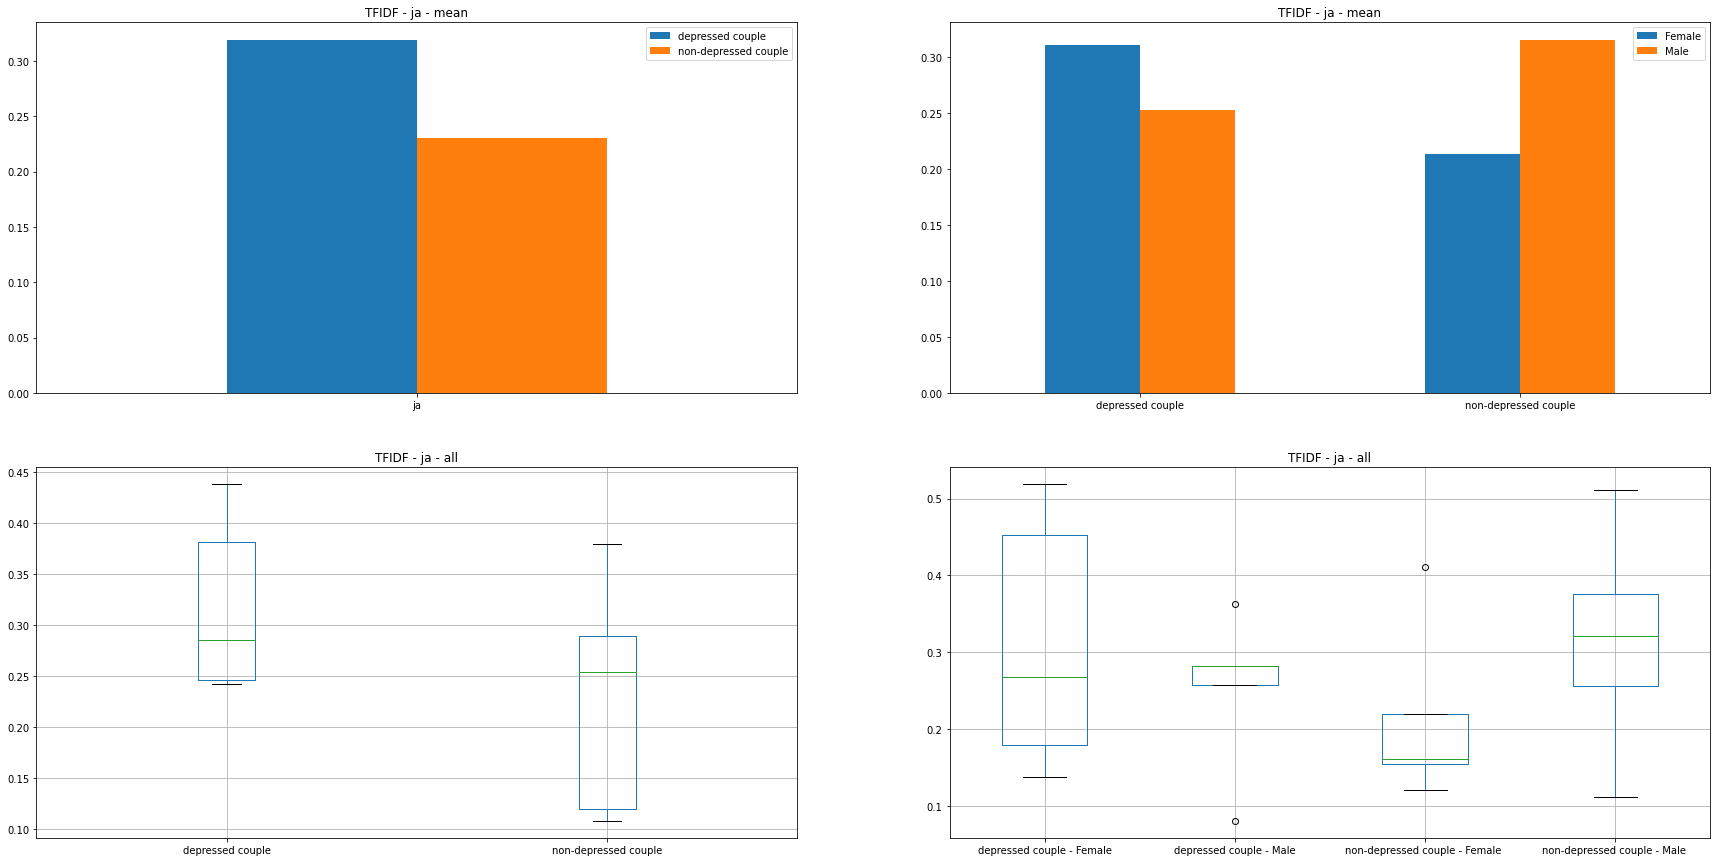

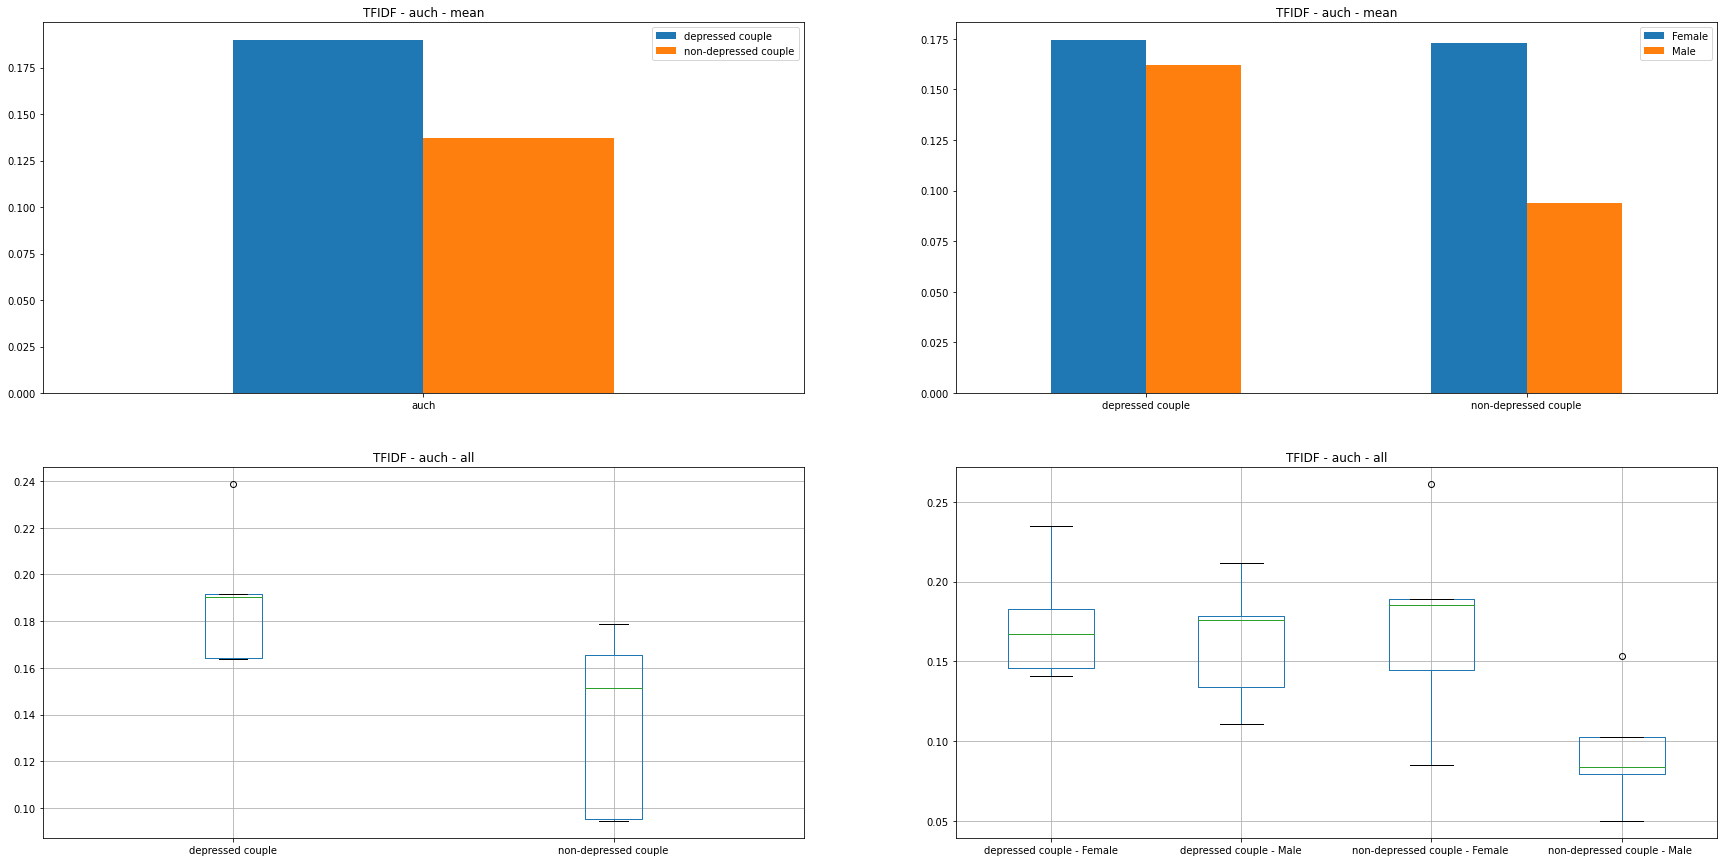

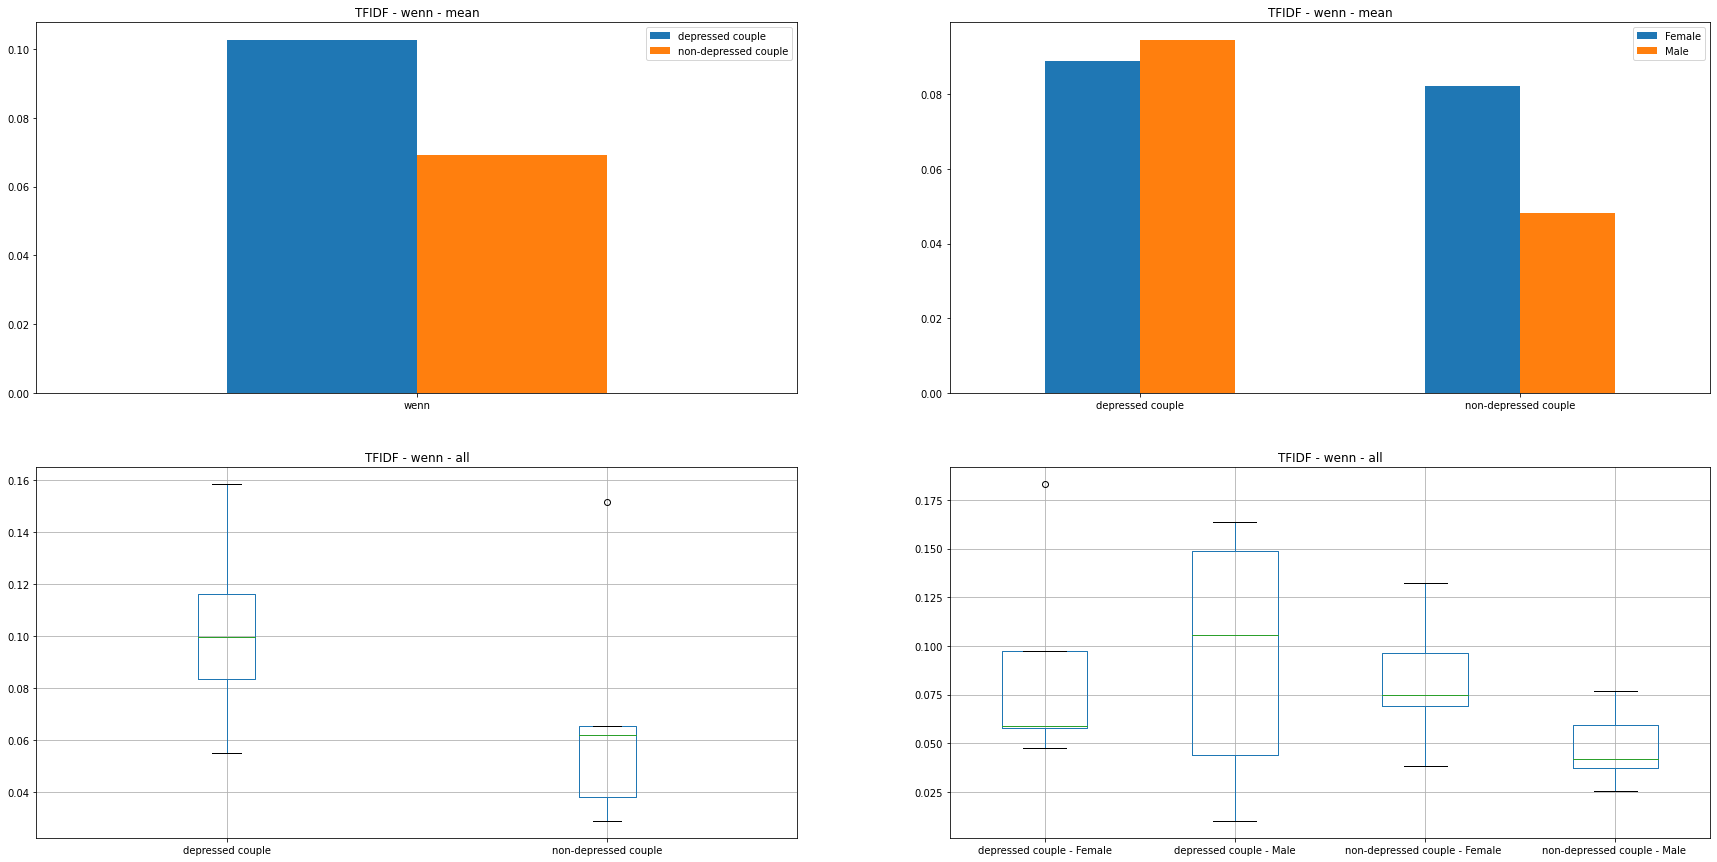

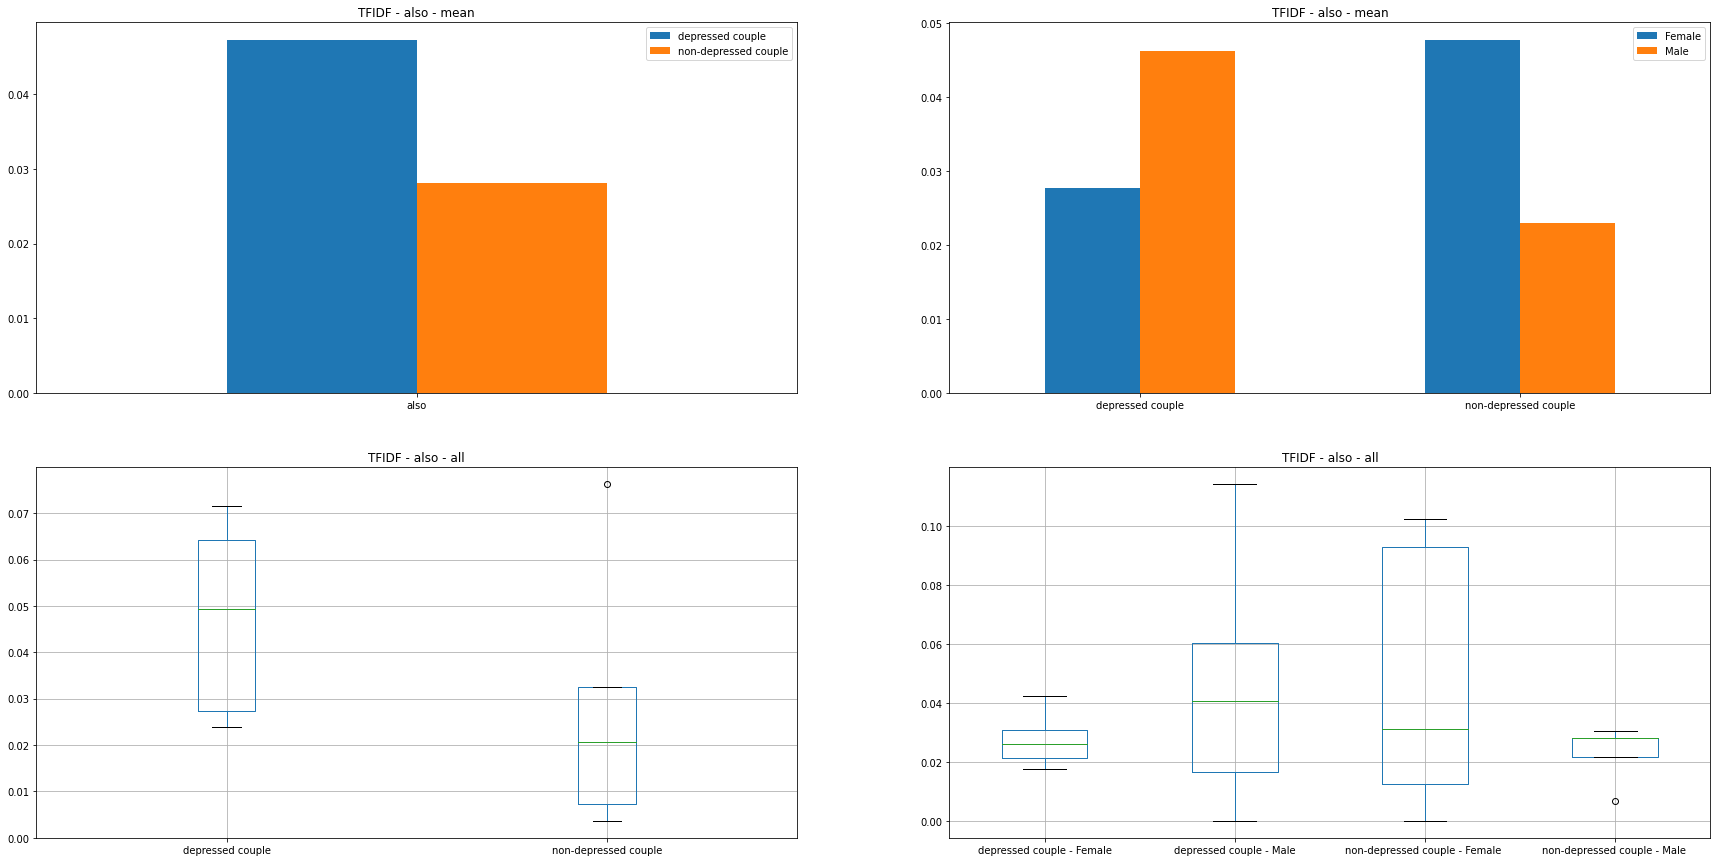

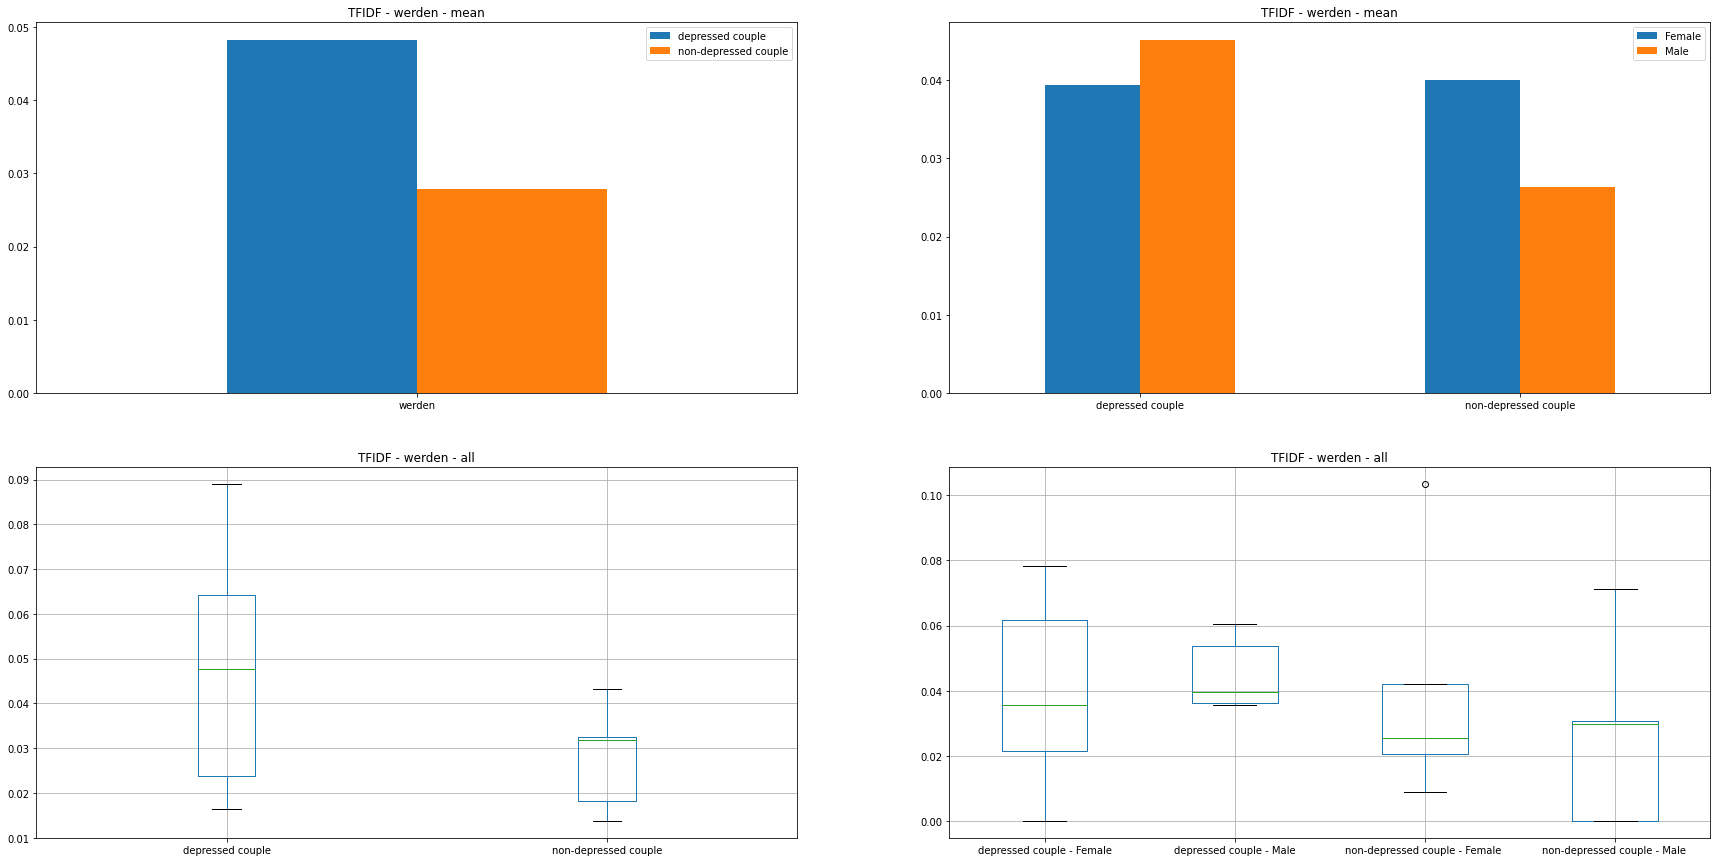

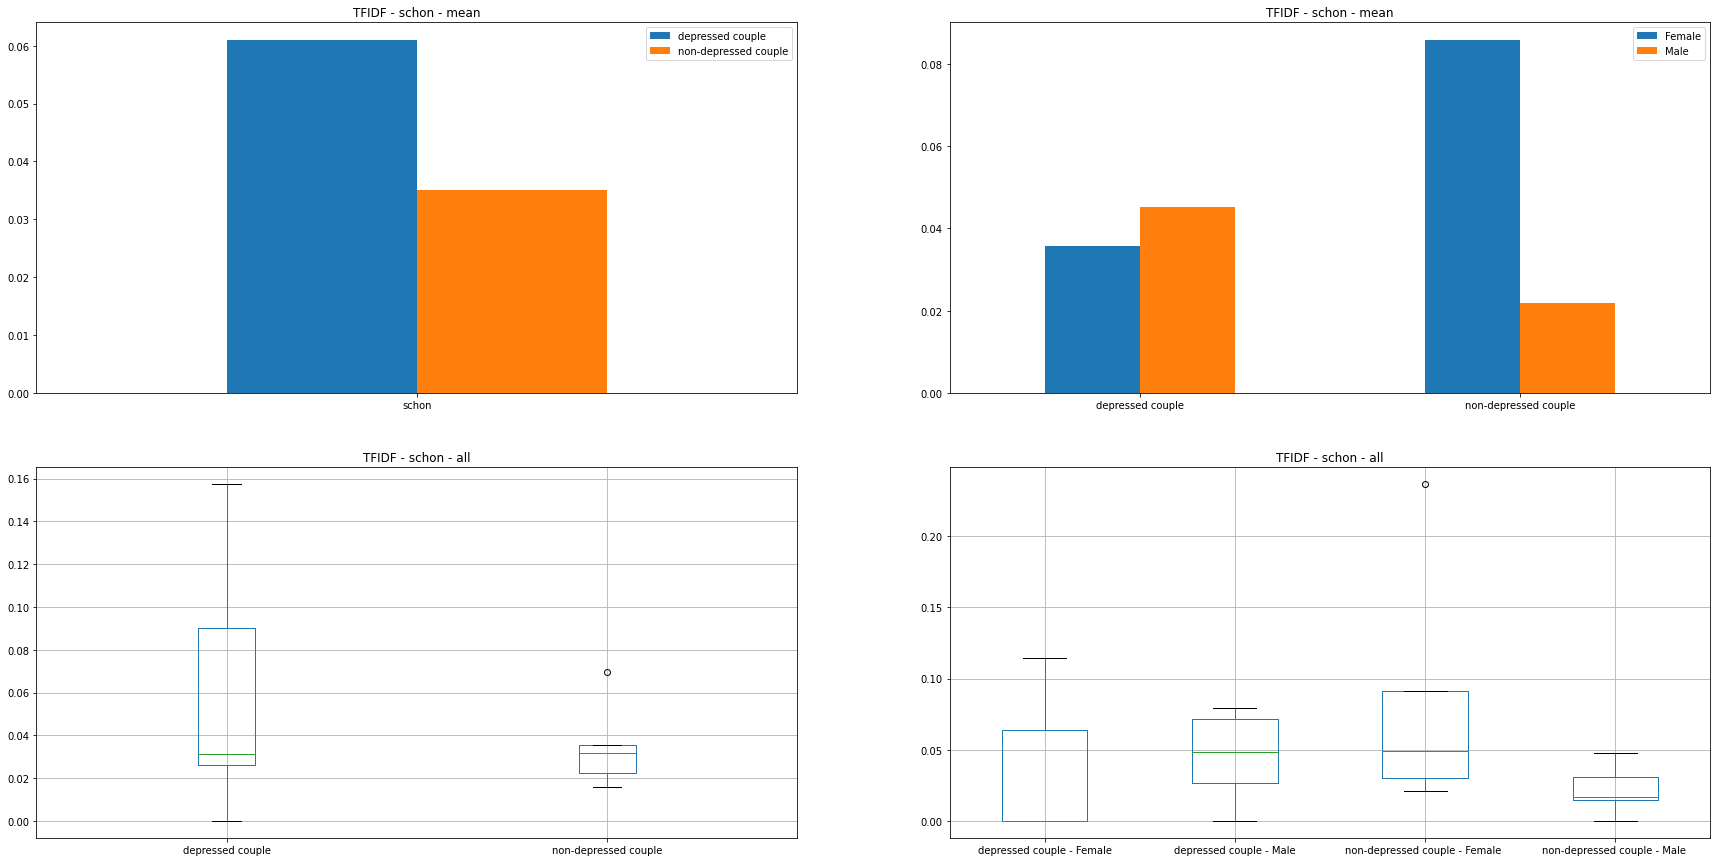

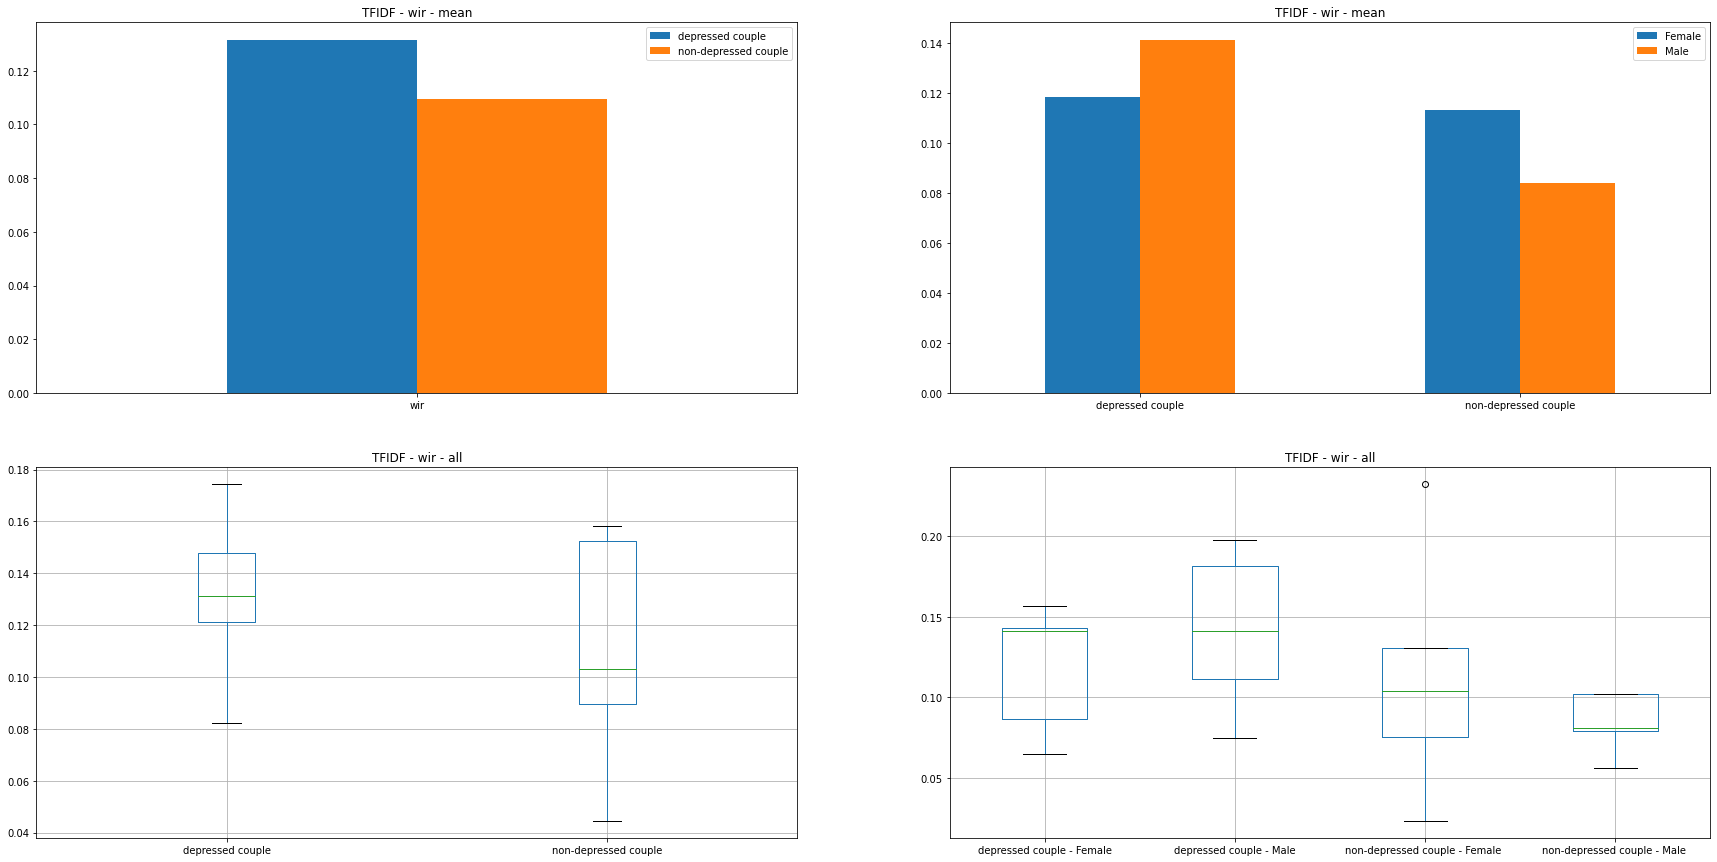

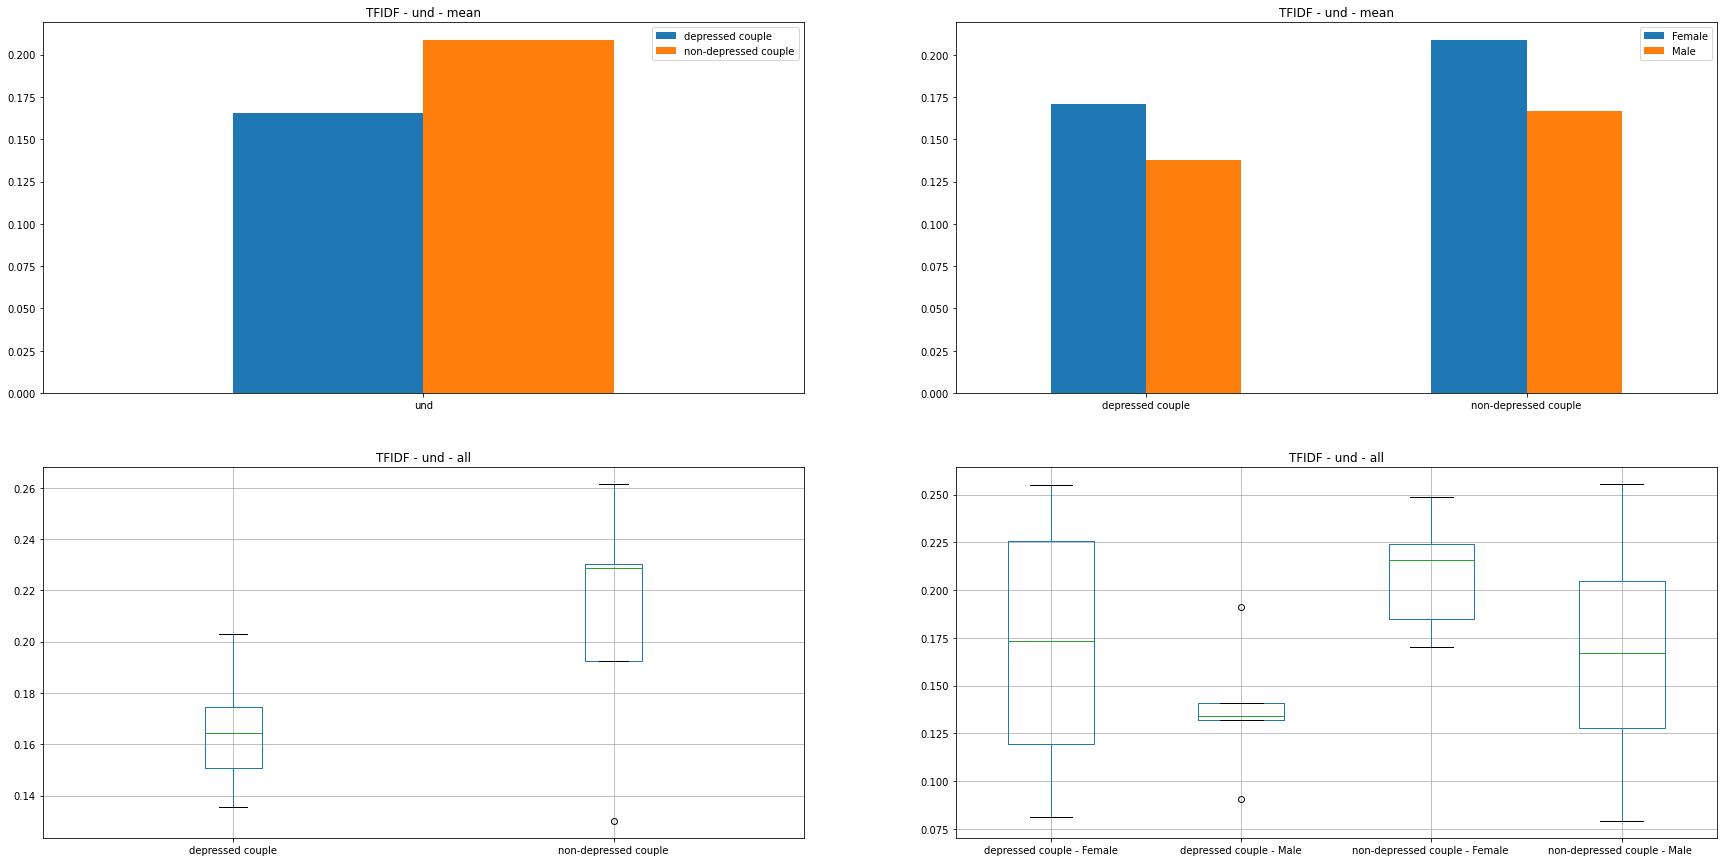

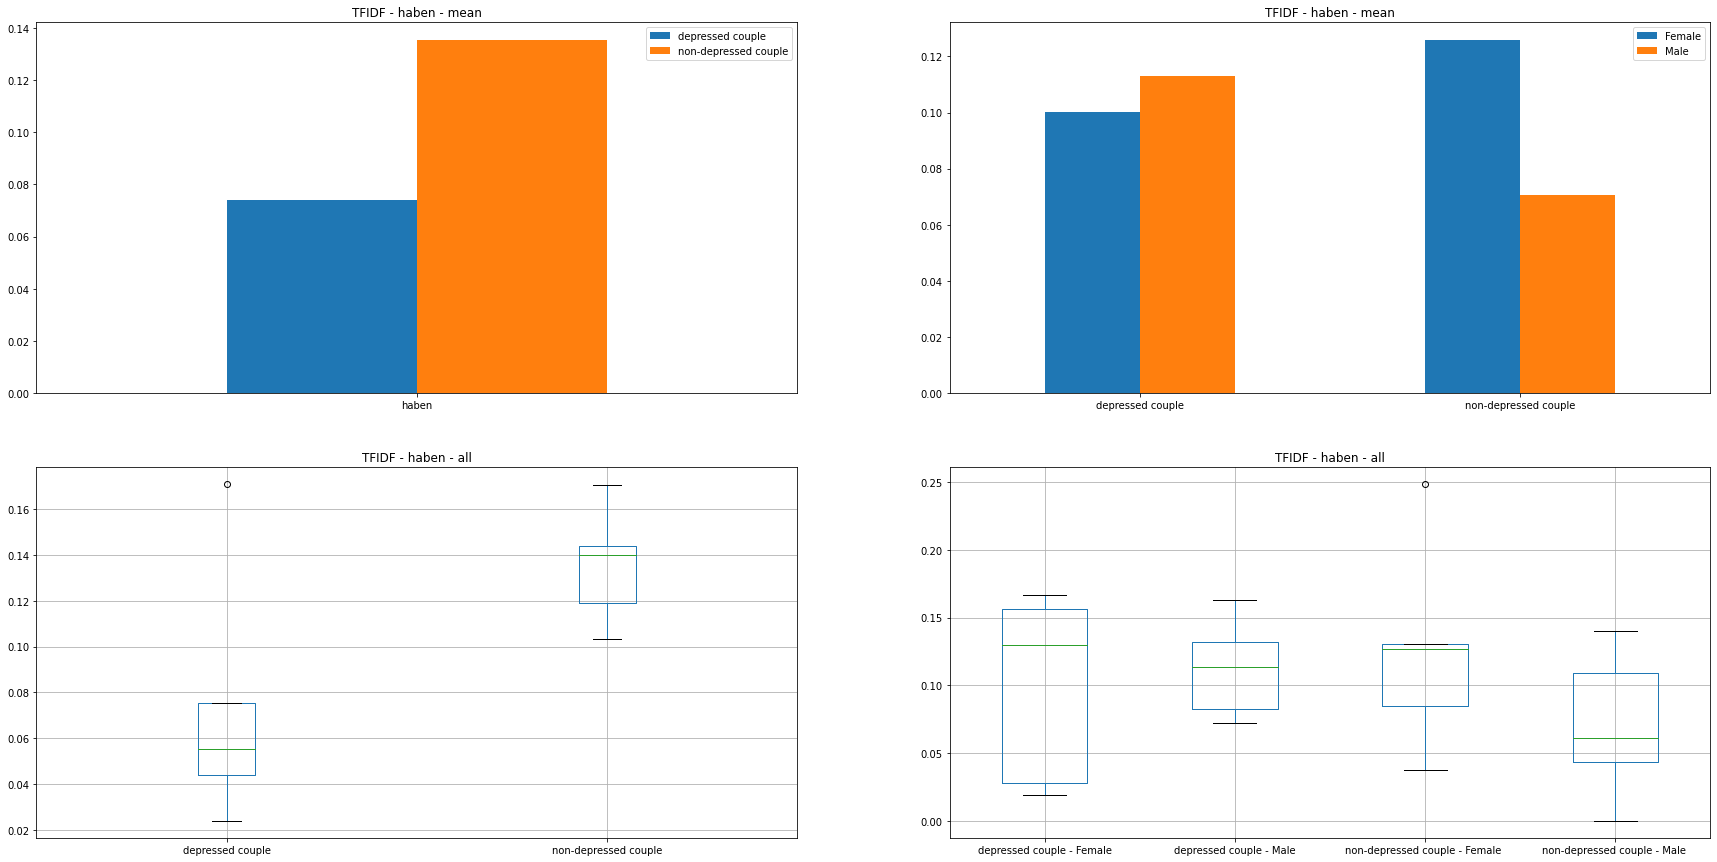

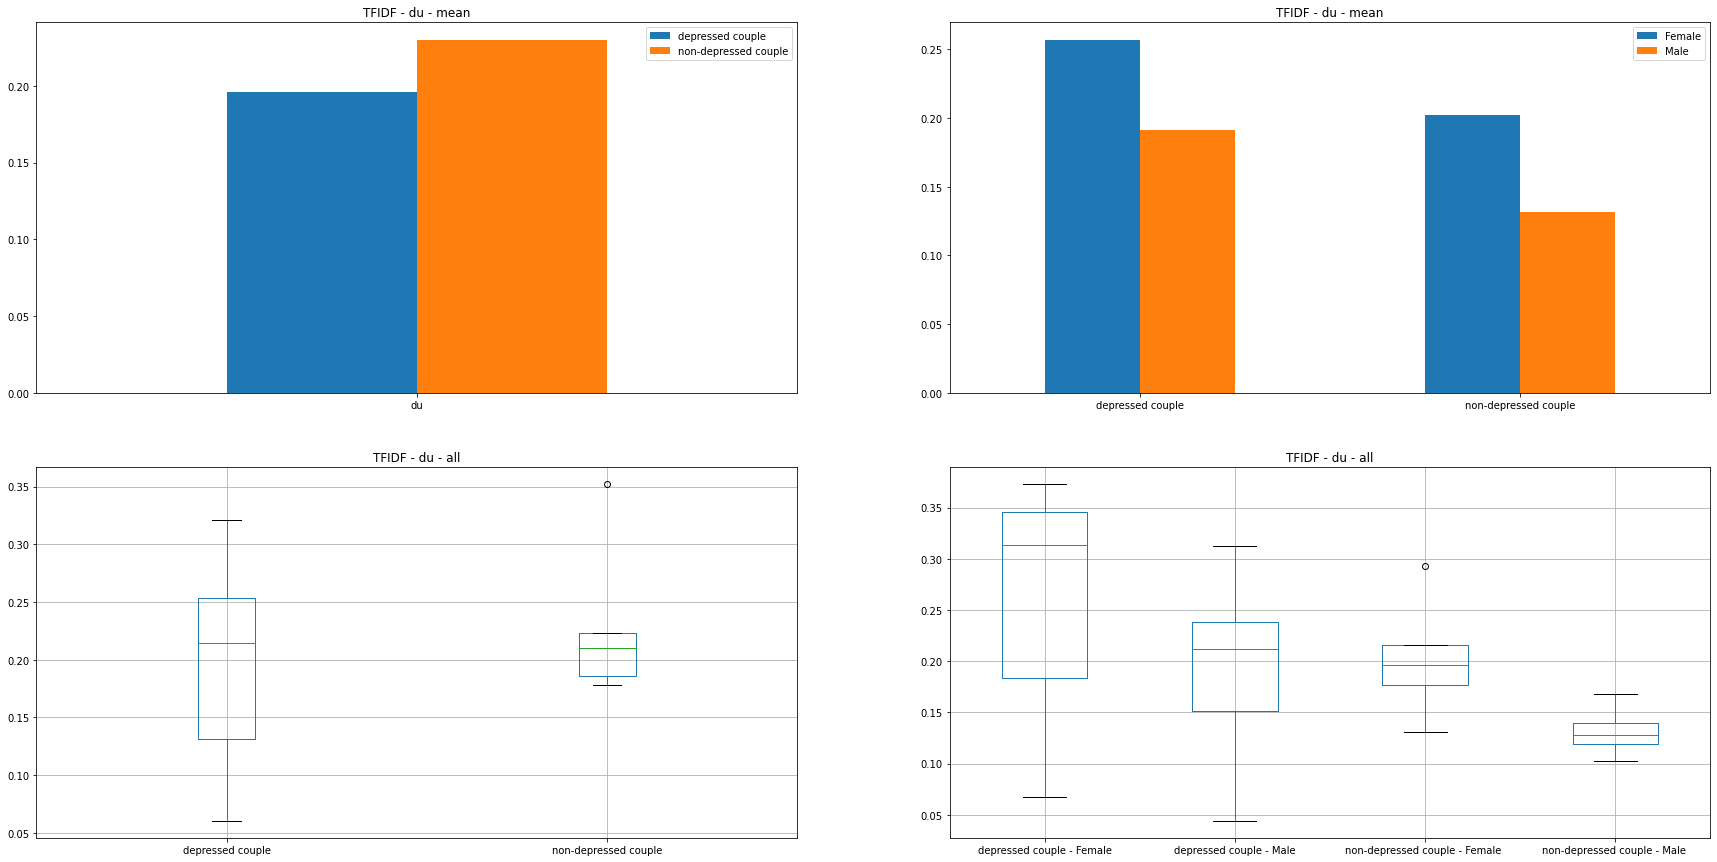

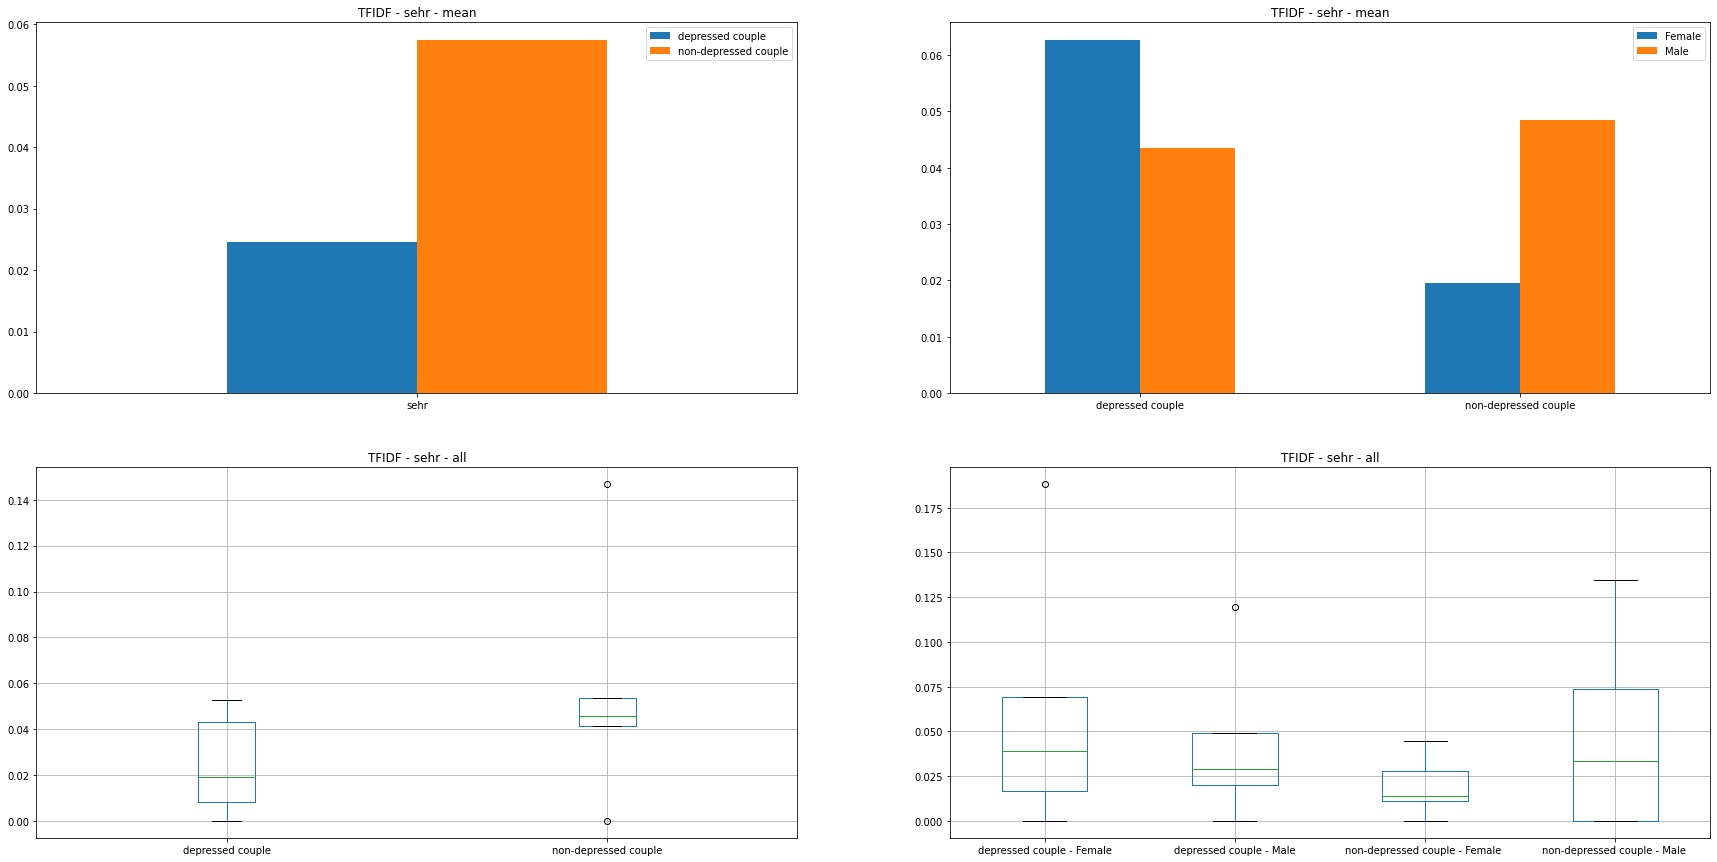

<Figure size 432x288 with 0 Axes>

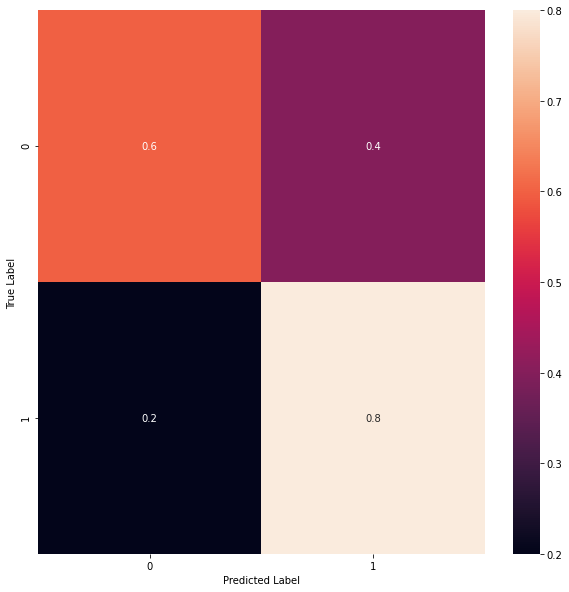

Executing Liwc
Executing NaiveBayes for [liwc_document_mf(feature)]


,couple_id,is_depressed_group,document_id,Posemo,Past,Present,Future,Metaph,Death,Affect,Incl,Achieve
0,27,True,0,112.0,21.0,97.0,1.0,15.0,2.0,120.0,63.0,34.0
1,182,False,1,55.0,22.0,103.0,0.0,3.0,0.0,78.0,70.0,28.0
2,81,False,2,102.0,76.0,148.0,6.0,2.0,0.0,115.0,135.0,37.0
3,47,True,3,51.0,9.0,68.0,3.0,7.0,2.0,60.0,47.0,23.0
4,58,False,4,73.0,49.0,96.0,7.0,6.0,1.0,91.0,89.0,30.0
5,29,False,5,62.0,58.0,106.0,3.0,7.0,2.0,72.0,77.0,26.0
6,105,True,6,81.0,30.0,96.0,6.0,2.0,0.0,86.0,67.0,30.0
7,60,True,7,51.0,31.0,92.0,8.0,8.0,3.0,71.0,65.0,42.0
8,138,True,8,61.0,39.0,97.0,4.0,7.0,3.0,68.0,83.0,33.0
9,87,False,9,73.0,33.0,108.0,2.0,5.0,2.0,79.0,78.0,31.0


'----------------------------------------'

'Prediction from one cross-validation'

,couple_id,is_depressed_group,predicted
0,27,1,1
1,182,0,0
2,81,0,0
3,47,1,1
4,58,0,0
5,29,0,0
6,105,1,1
7,60,1,1
8,138,1,0
9,87,0,0


'Scores from 4 cross-validation(s)'

'----------------------------------------'

'Accuracy: [array([0.5, 1. , 0.5, 1. , 0.5]), array([1. , 1. , 0.5, 0.5, 1. ]), array([1. , 0.5, 1. , 0.5, 0.5]), array([1. , 0.5, 1. , 1. , 0.5])]'

'Mean of each: [0.7, 0.8, 0.7, 0.8] | Var of each: [0.06, 0.06, 0.06, 0.06]'

'Overall max: 0.8 | Overall mean: 0.75 | Overall variance: 0.06'

'----------------------------------------'

'F1-score: [0.888888888888889, 0.888888888888889, 0.888888888888889, 0.888888888888889]'

'Mean of each: [0.888888888888889, 0.888888888888889, 0.888888888888889, 0.888888888888889] | Var of each: [0.0, 0.0, 0.0, 0.0]'

'Overall max: 0.888888888888889 | Overall mean: 0.888888888888889 | Overall variance: 0.0'

'----------------------------------------'

,couple_id,is_depressed_group,predicted
0,27,1,1
1,182,0,0
2,81,0,0
3,47,1,1
4,58,0,0
5,29,0,0
6,105,1,1
7,60,1,1
8,138,1,0
9,87,0,0


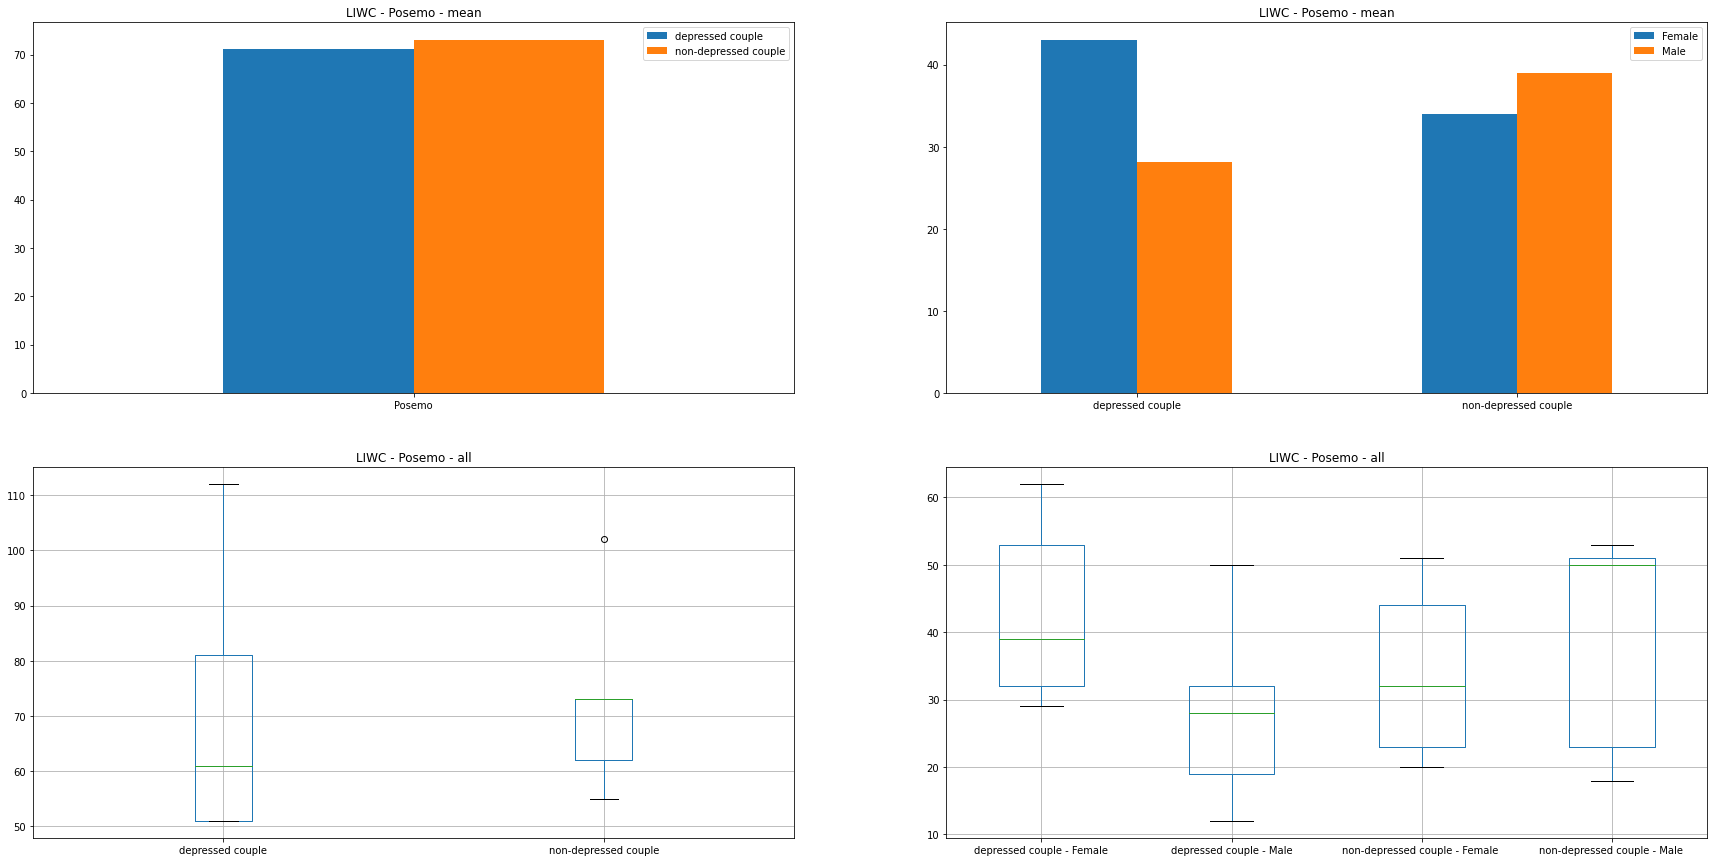

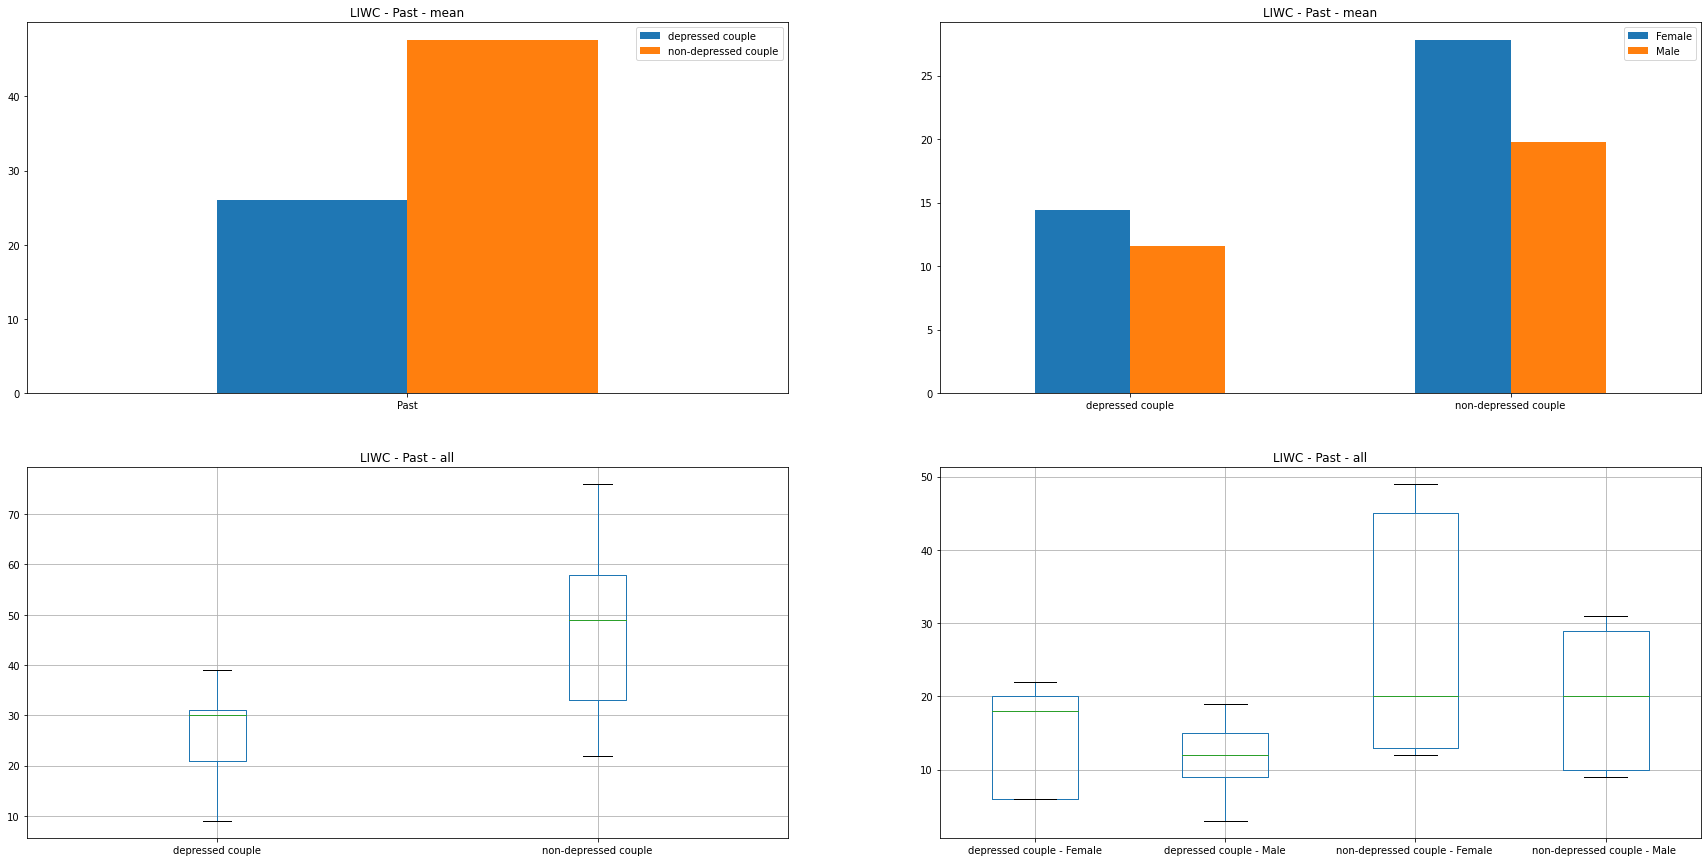

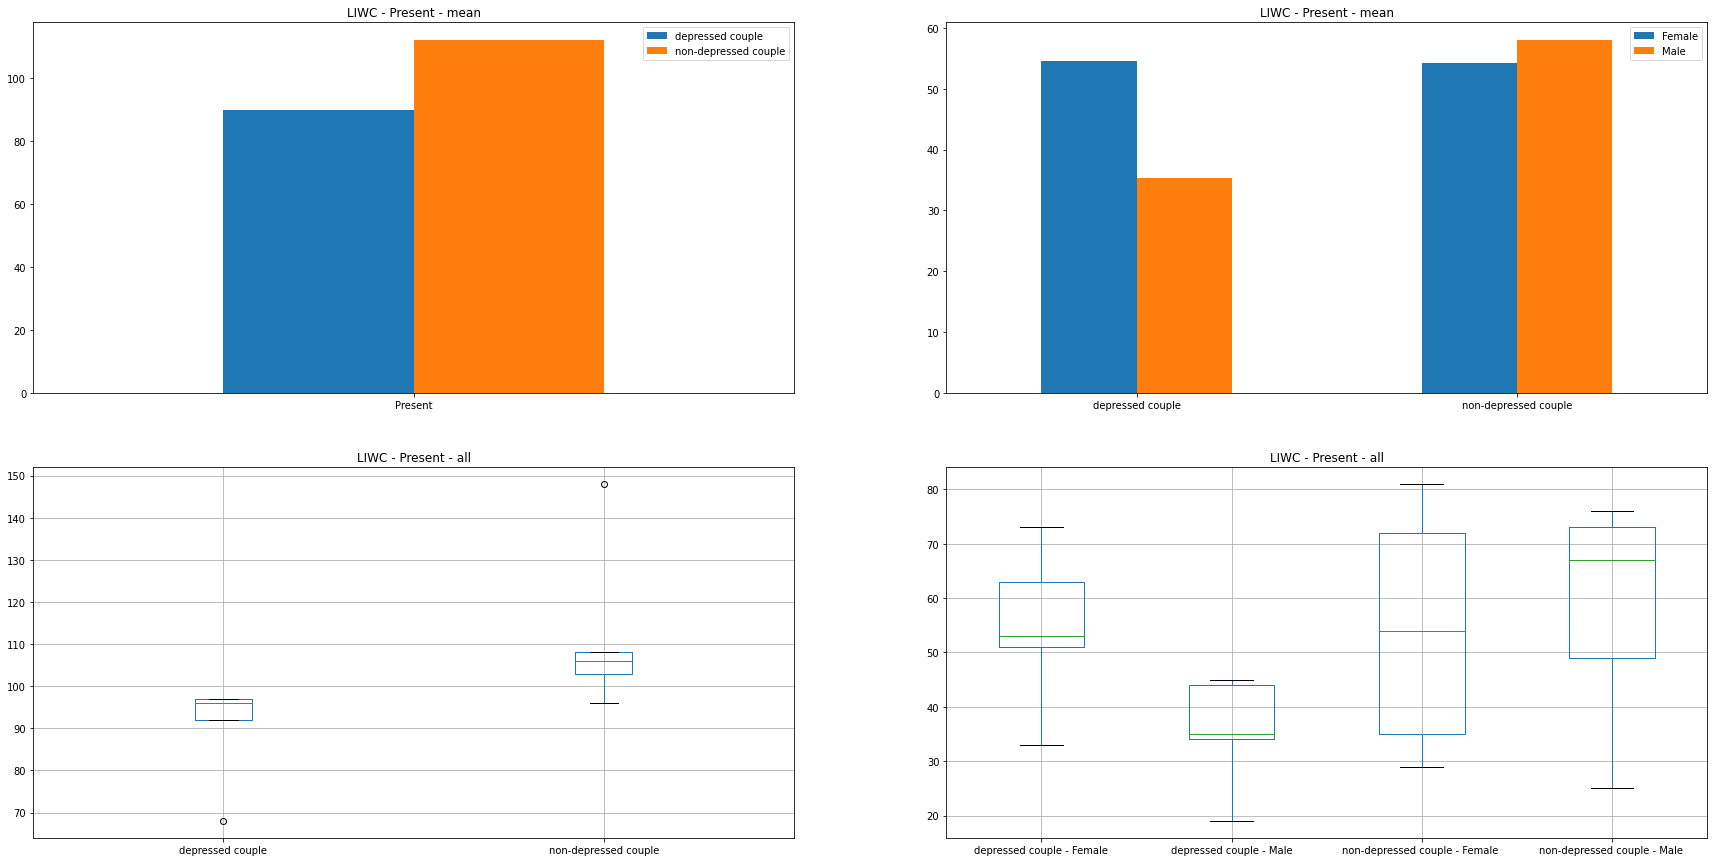

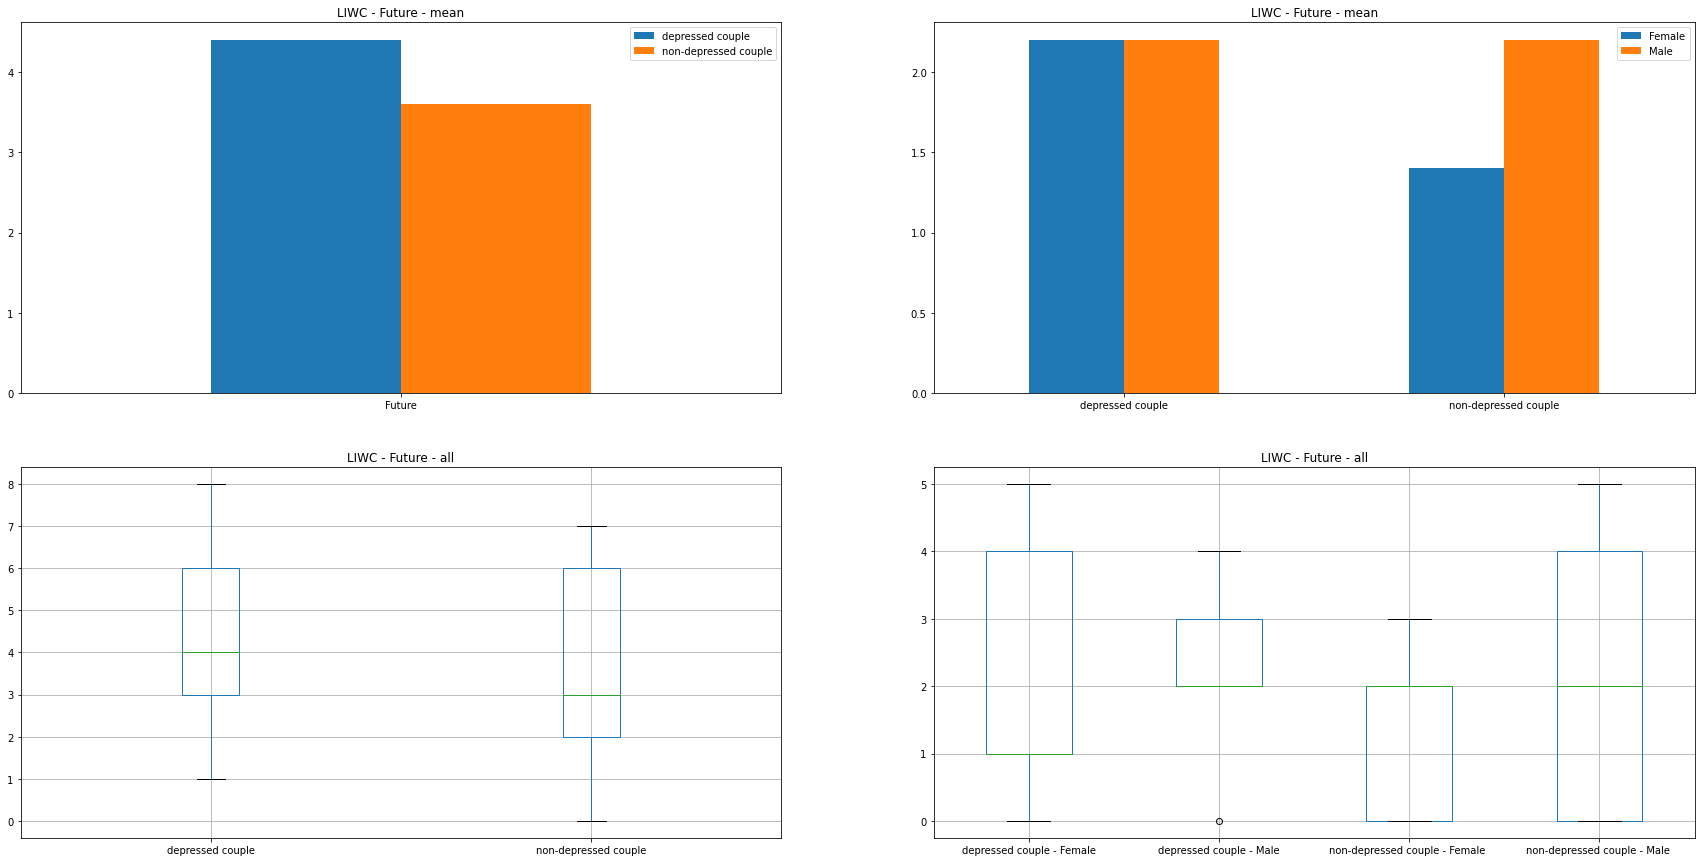

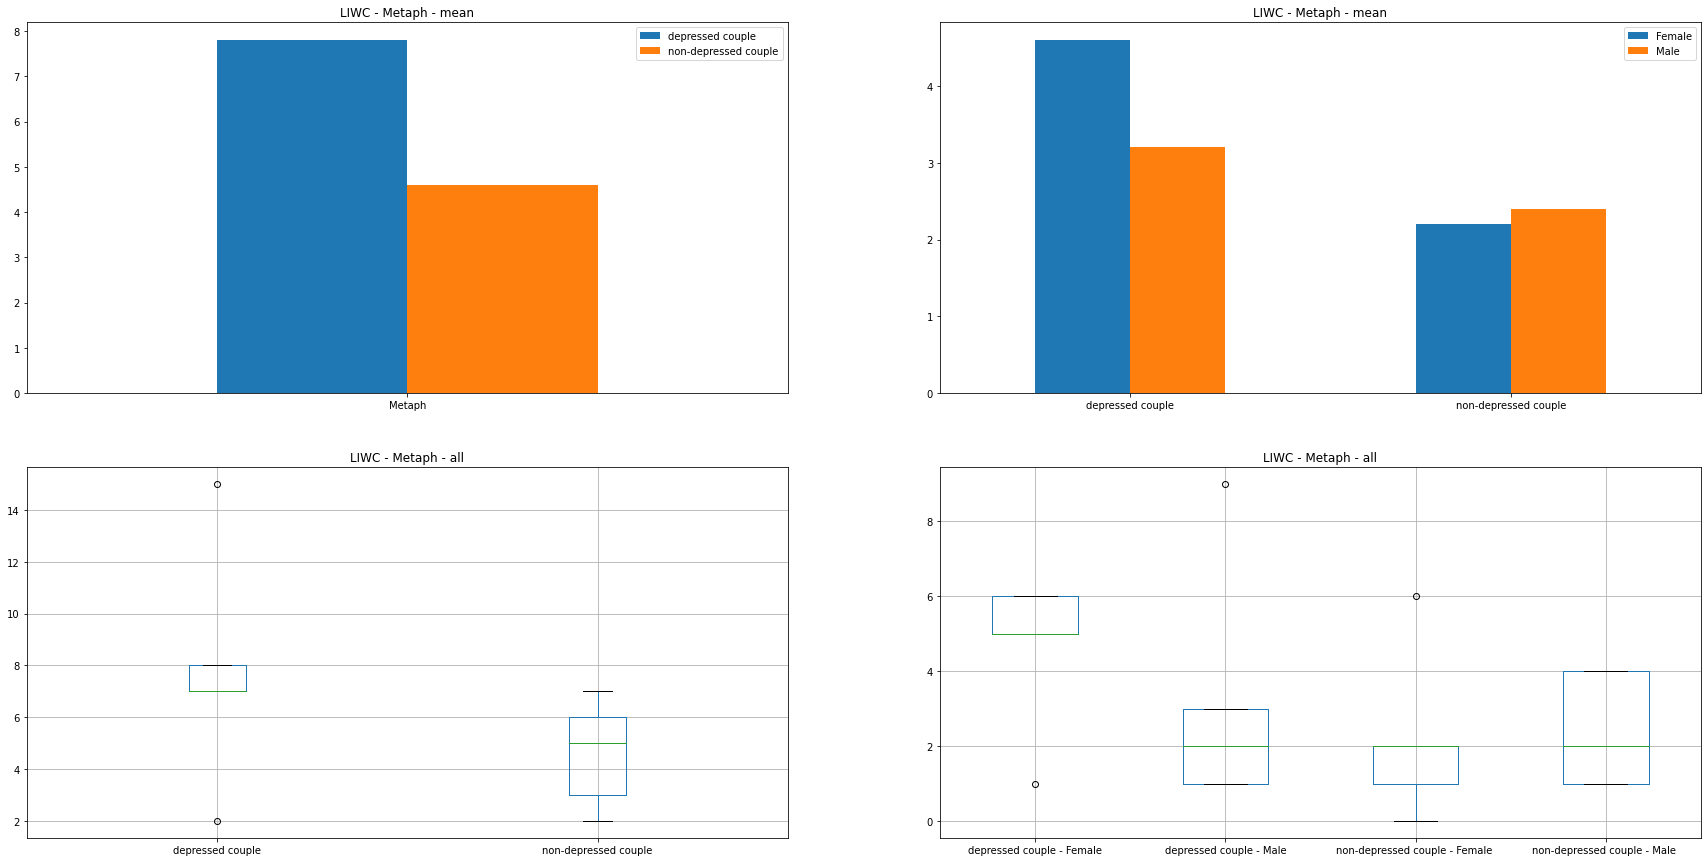

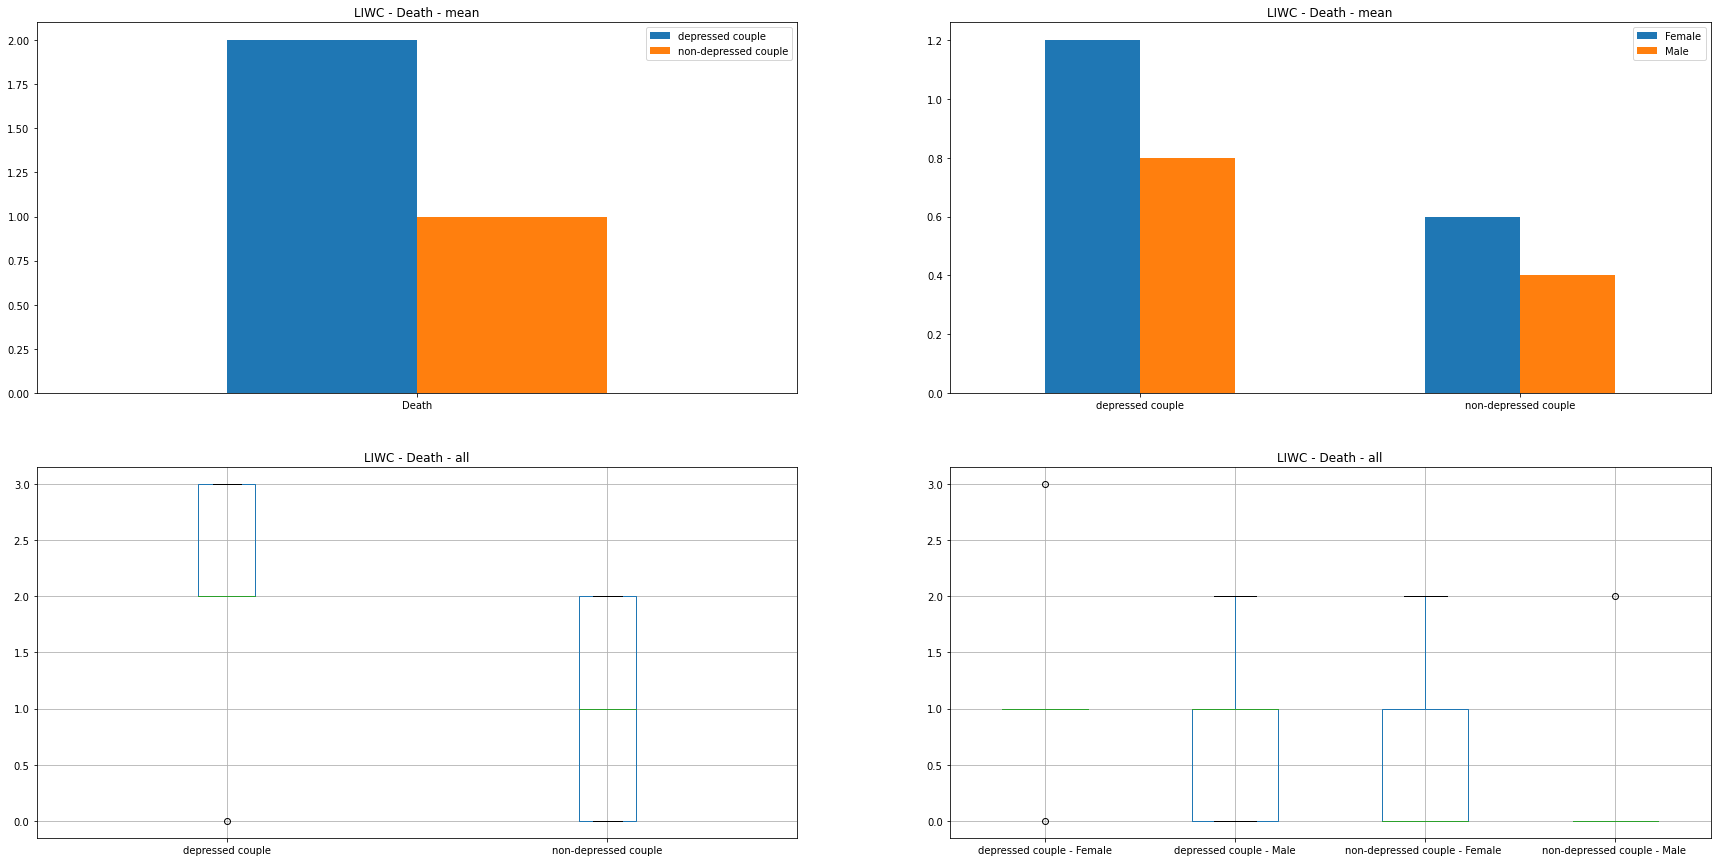

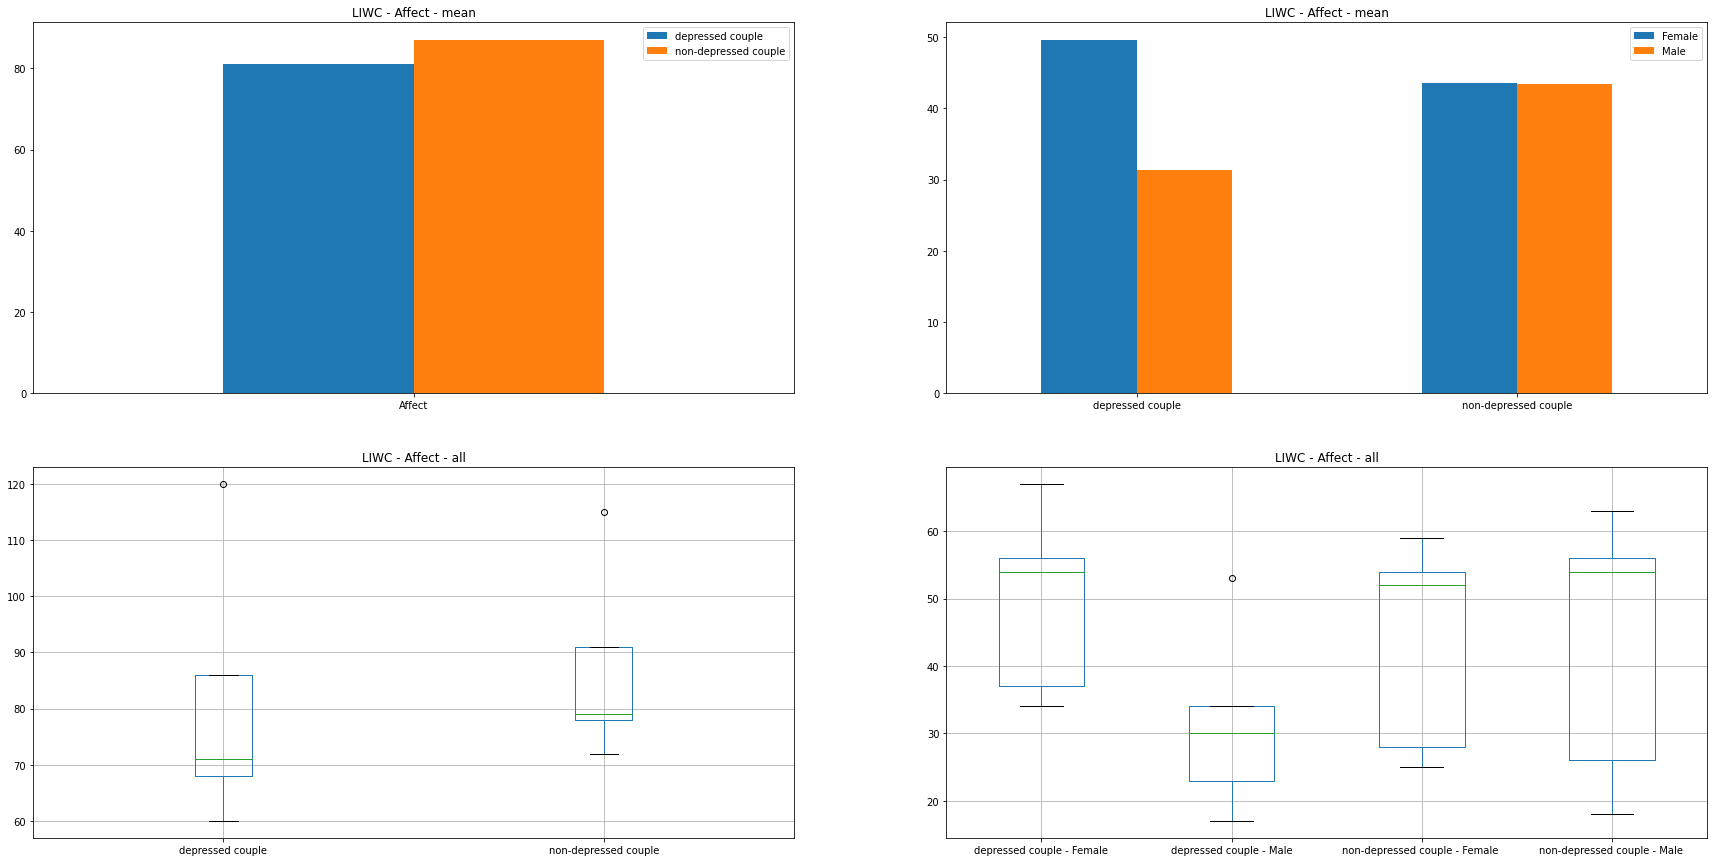

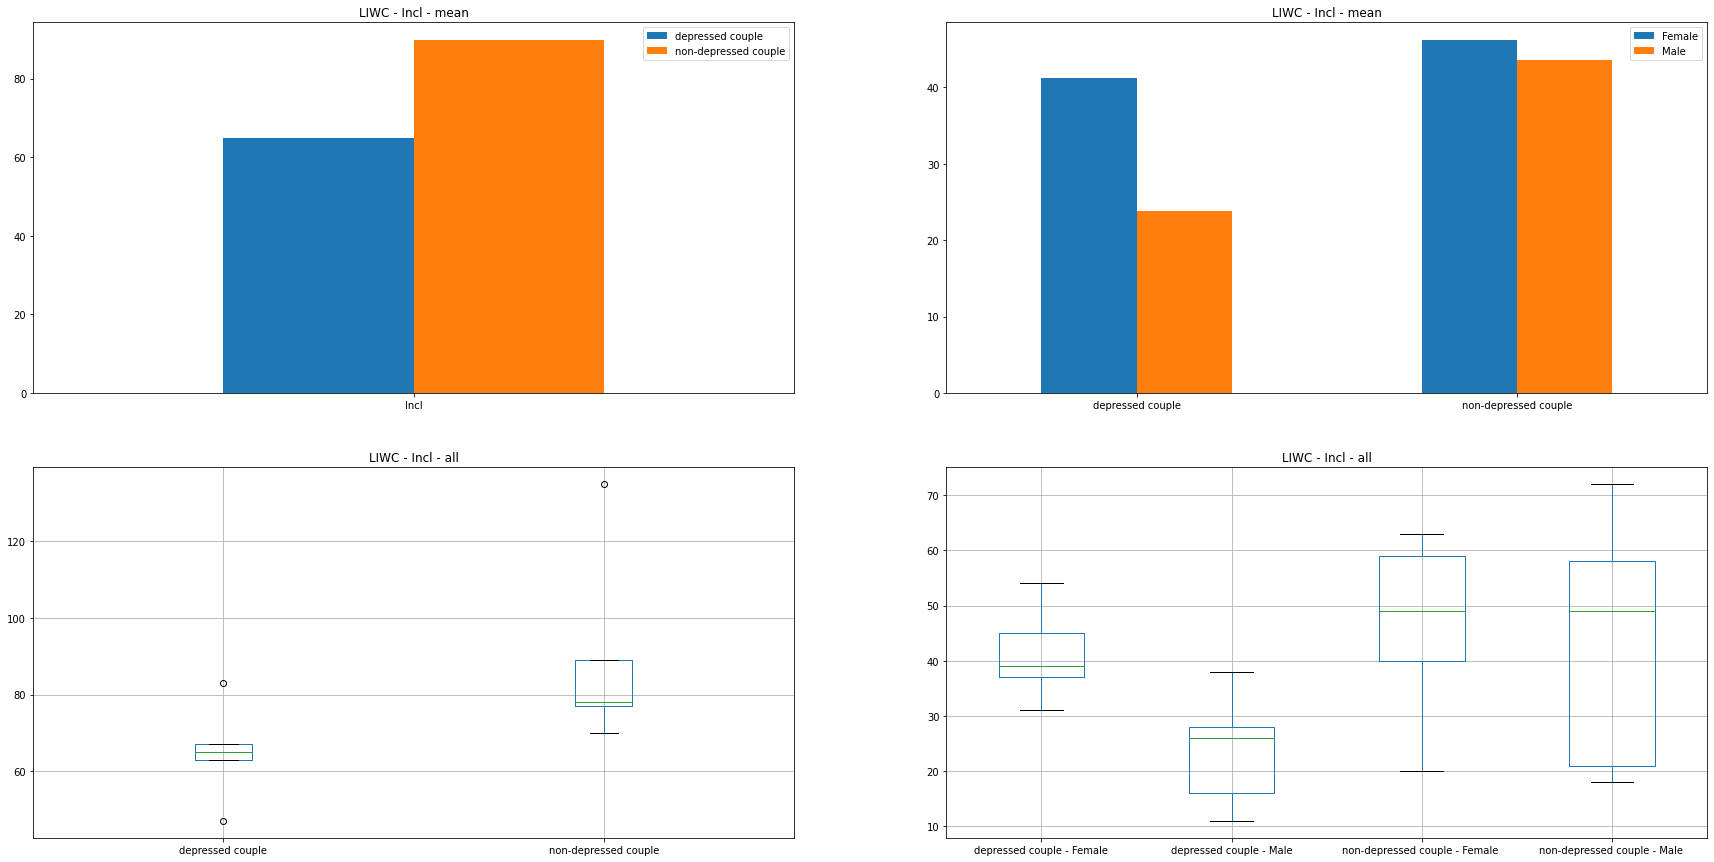

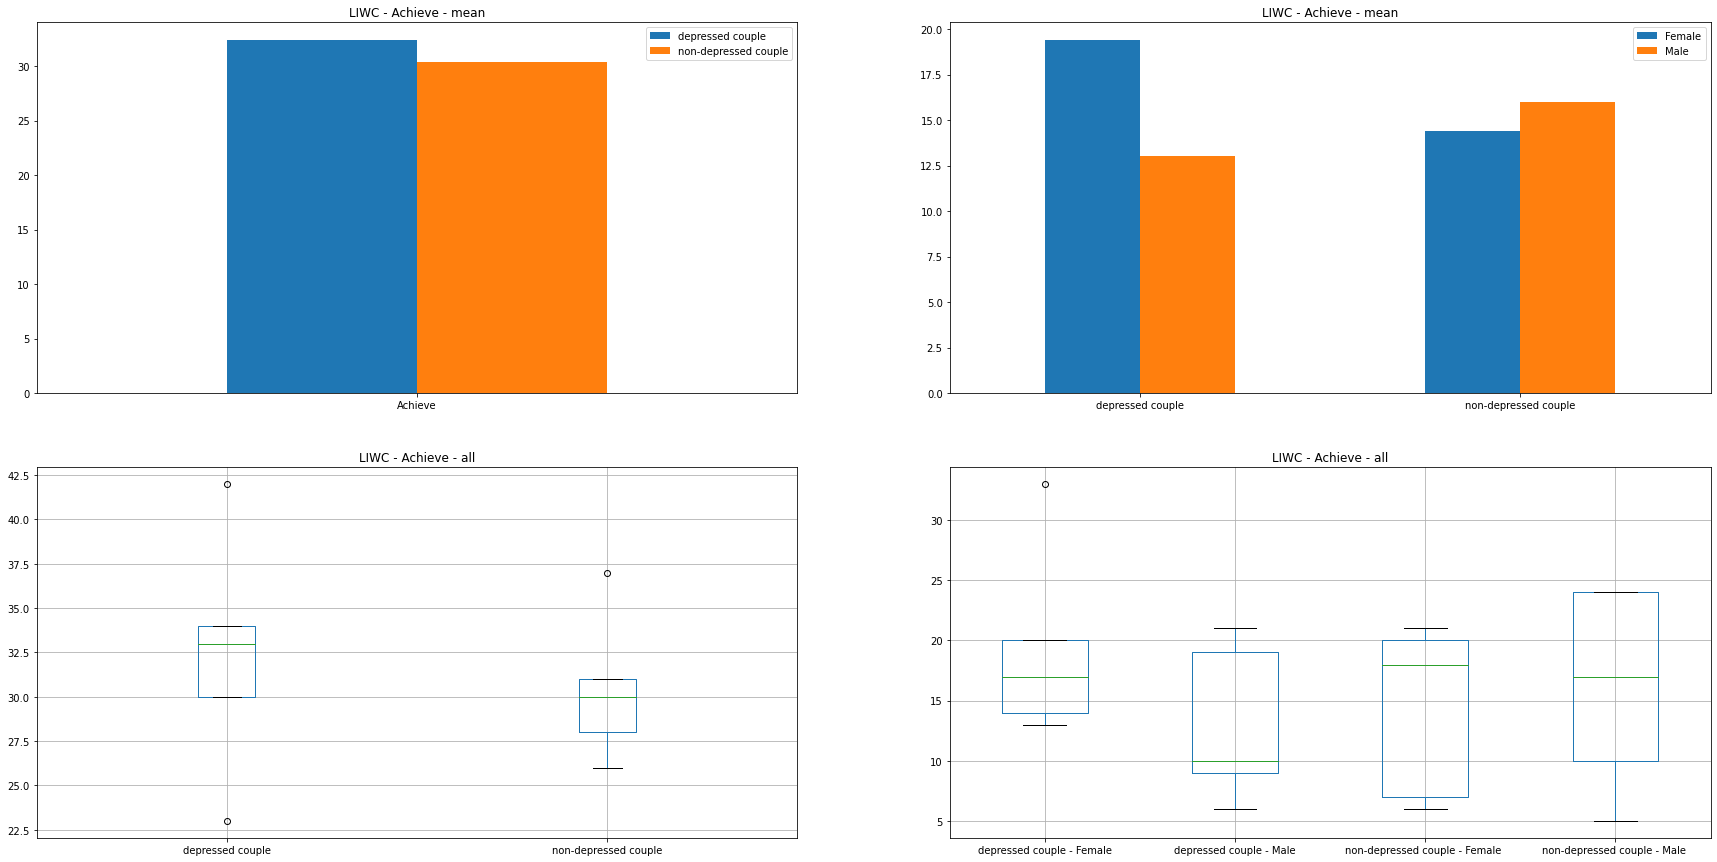

<Figure size 432x288 with 0 Axes>

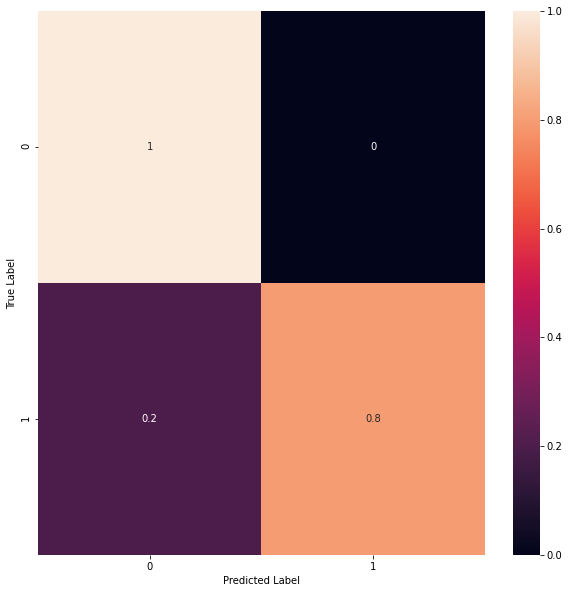

Executing PartOfSpeech
Executing NaiveBayes for [pos_document_mf(feature)]


,couple_id,is_depressed_group,document_id,ADV,PPER,ADJD,VAFIN,KON
0,27,True,0,147.0,172.0,72.0,62.0,29.0
1,182,False,1,274.0,181.0,53.0,57.0,44.0
2,81,False,2,325.0,274.0,204.0,150.0,79.0
3,47,True,3,116.0,85.0,53.0,34.0,24.0
4,58,False,4,196.0,160.0,84.0,71.0,42.0
5,29,False,5,231.0,161.0,67.0,88.0,44.0
6,105,True,6,219.0,187.0,70.0,70.0,28.0
7,60,True,7,237.0,148.0,71.0,70.0,25.0
8,138,True,8,363.0,162.0,66.0,76.0,43.0
9,87,False,9,321.0,205.0,76.0,70.0,45.0


'----------------------------------------'

'Prediction from one cross-validation'

,couple_id,is_depressed_group,predicted
0,27,1,0
1,182,0,1
2,81,0,0
3,47,1,0
4,58,0,0
5,29,0,1
6,105,1,1
7,60,1,1
8,138,1,1
9,87,0,1


'Scores from 4 cross-validation(s)'

'----------------------------------------'

'Accuracy: [array([0.5, 0.5, 0.5, 0.5, 0. ]), array([0.5, 1. , 0.5, 0.5, 0. ]), array([0.5, 0.5, 0. , 0.5, 0.5]), array([0.5, 1. , 0. , 0. , 0.5])]'

'Mean of each: [0.4, 0.5, 0.4, 0.4] | Var of each: [0.04, 0.1, 0.04, 0.14]'

'Overall max: 0.5 | Overall mean: 0.42500000000000004 | Overall variance: 0.08000000000000002'

'----------------------------------------'

'F1-score: [0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454]'

'Mean of each: [0.5454545454545454, 0.5454545454545454, 0.5454545454545454, 0.5454545454545454] | Var of each: [0.0, 0.0, 0.0, 0.0]'

'Overall max: 0.5454545454545454 | Overall mean: 0.5454545454545454 | Overall variance: 0.0'

'----------------------------------------'

,couple_id,is_depressed_group,predicted
0,27,1,0
1,182,0,1
2,81,0,0
3,47,1,0
4,58,0,0
5,29,0,1
6,105,1,1
7,60,1,1
8,138,1,1
9,87,0,1


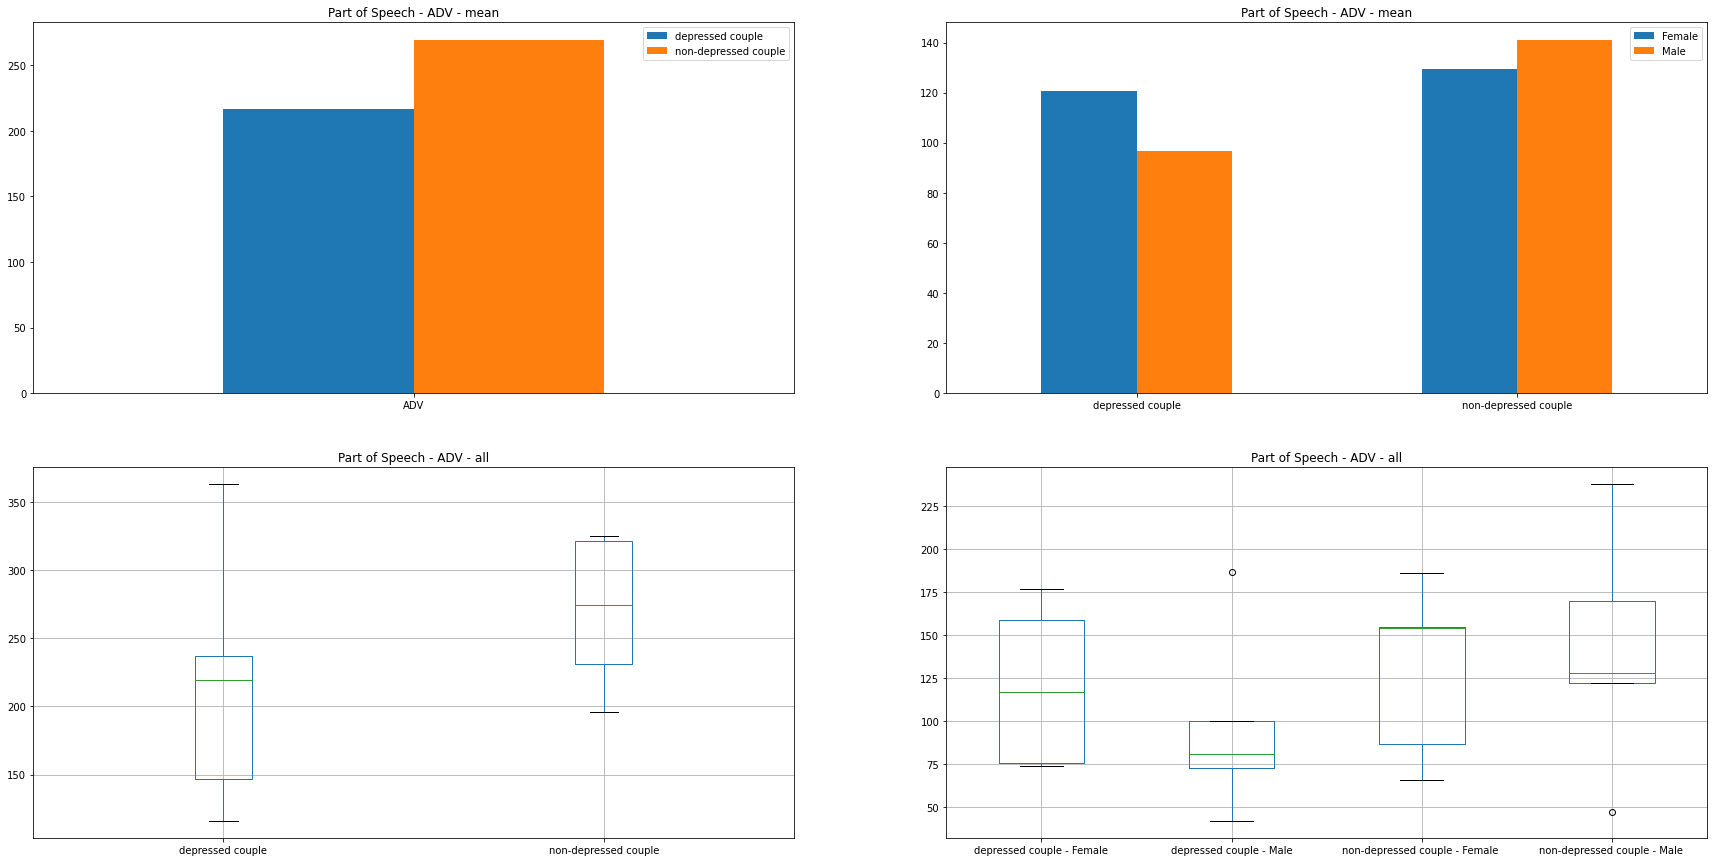

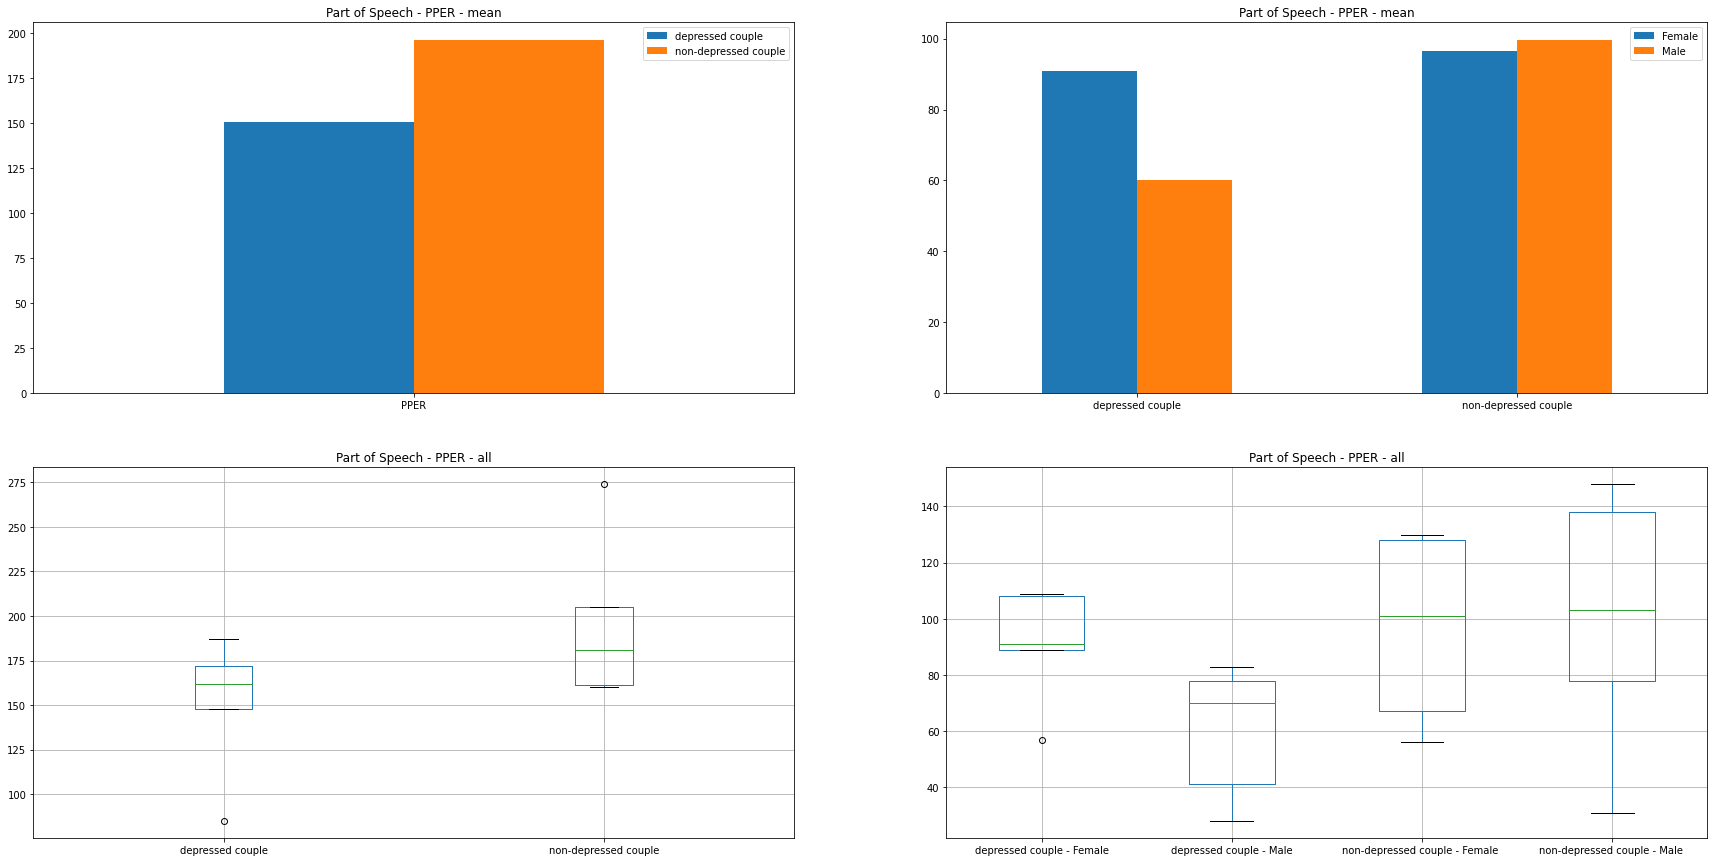

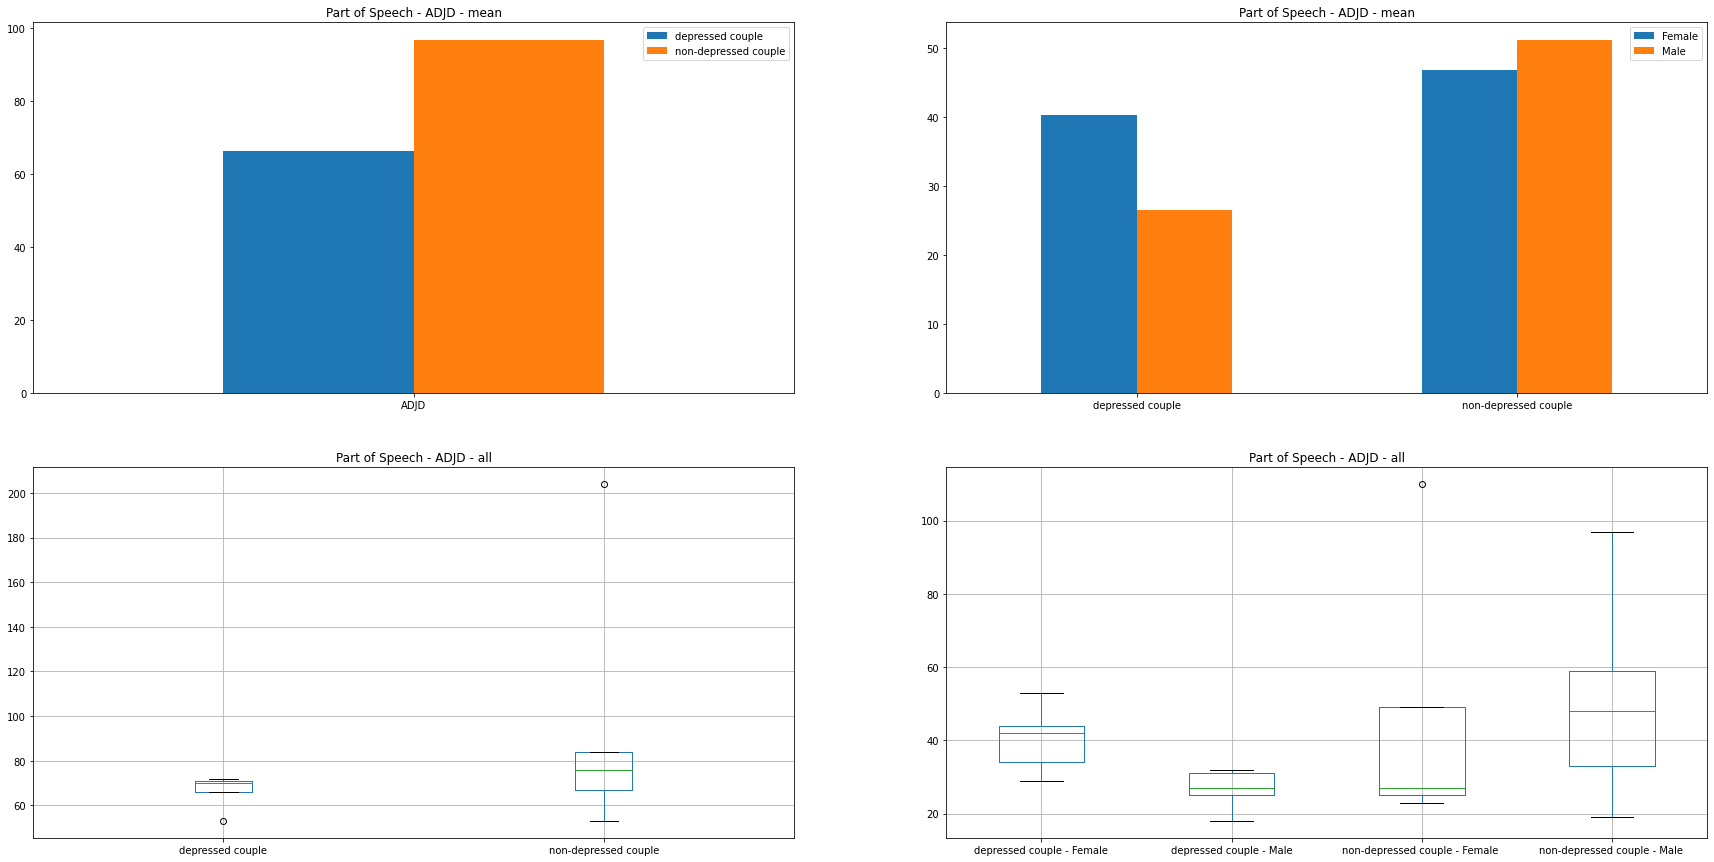

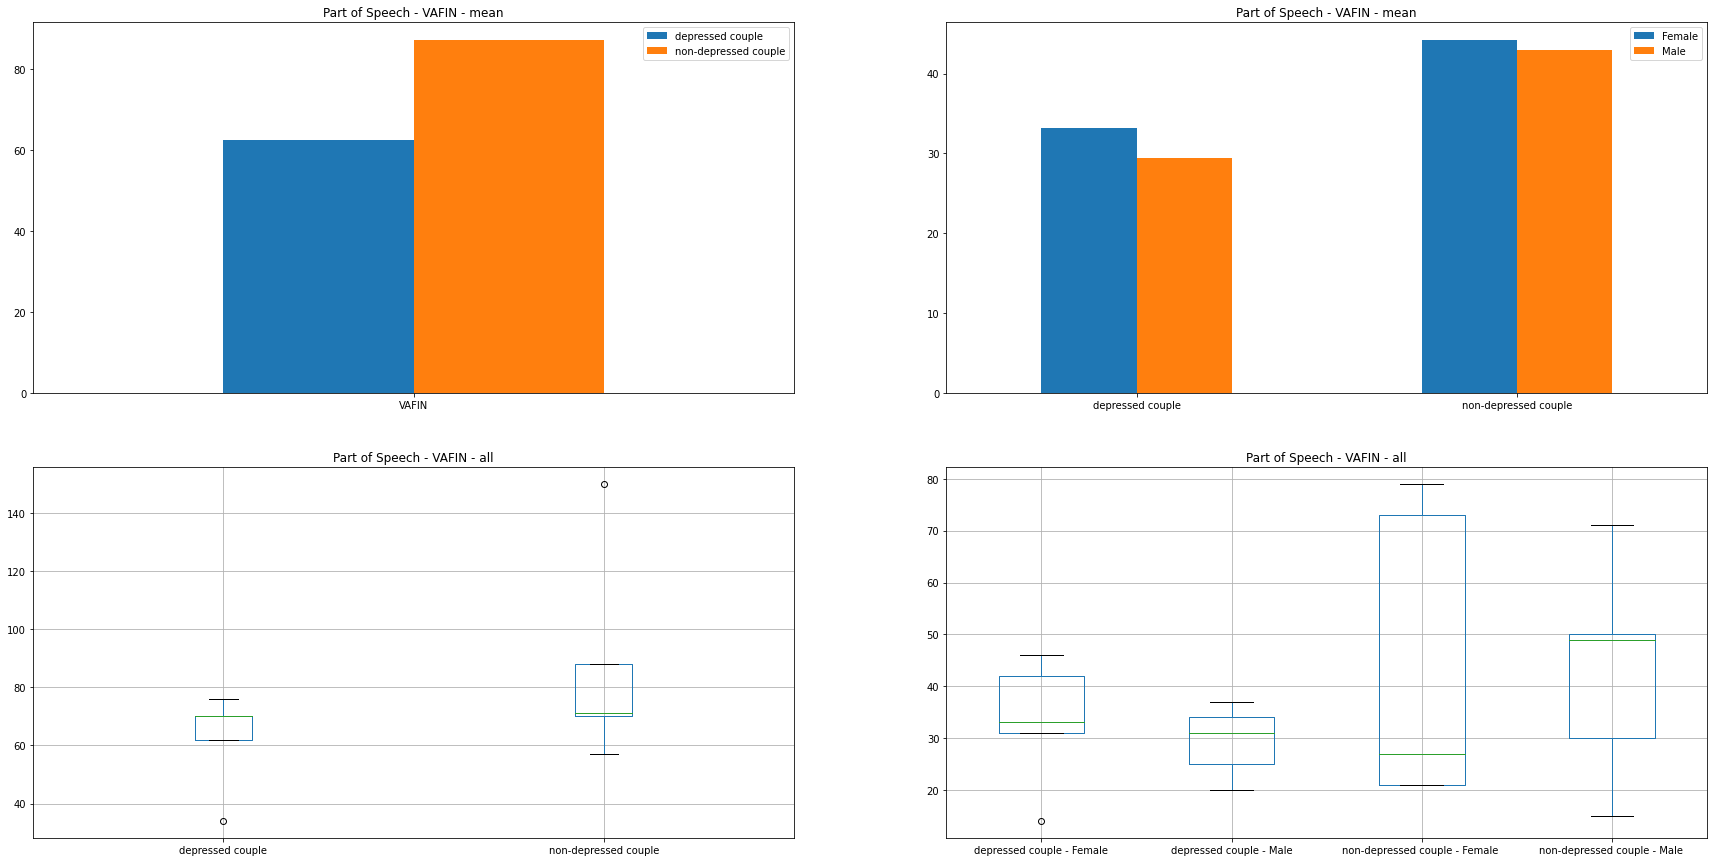

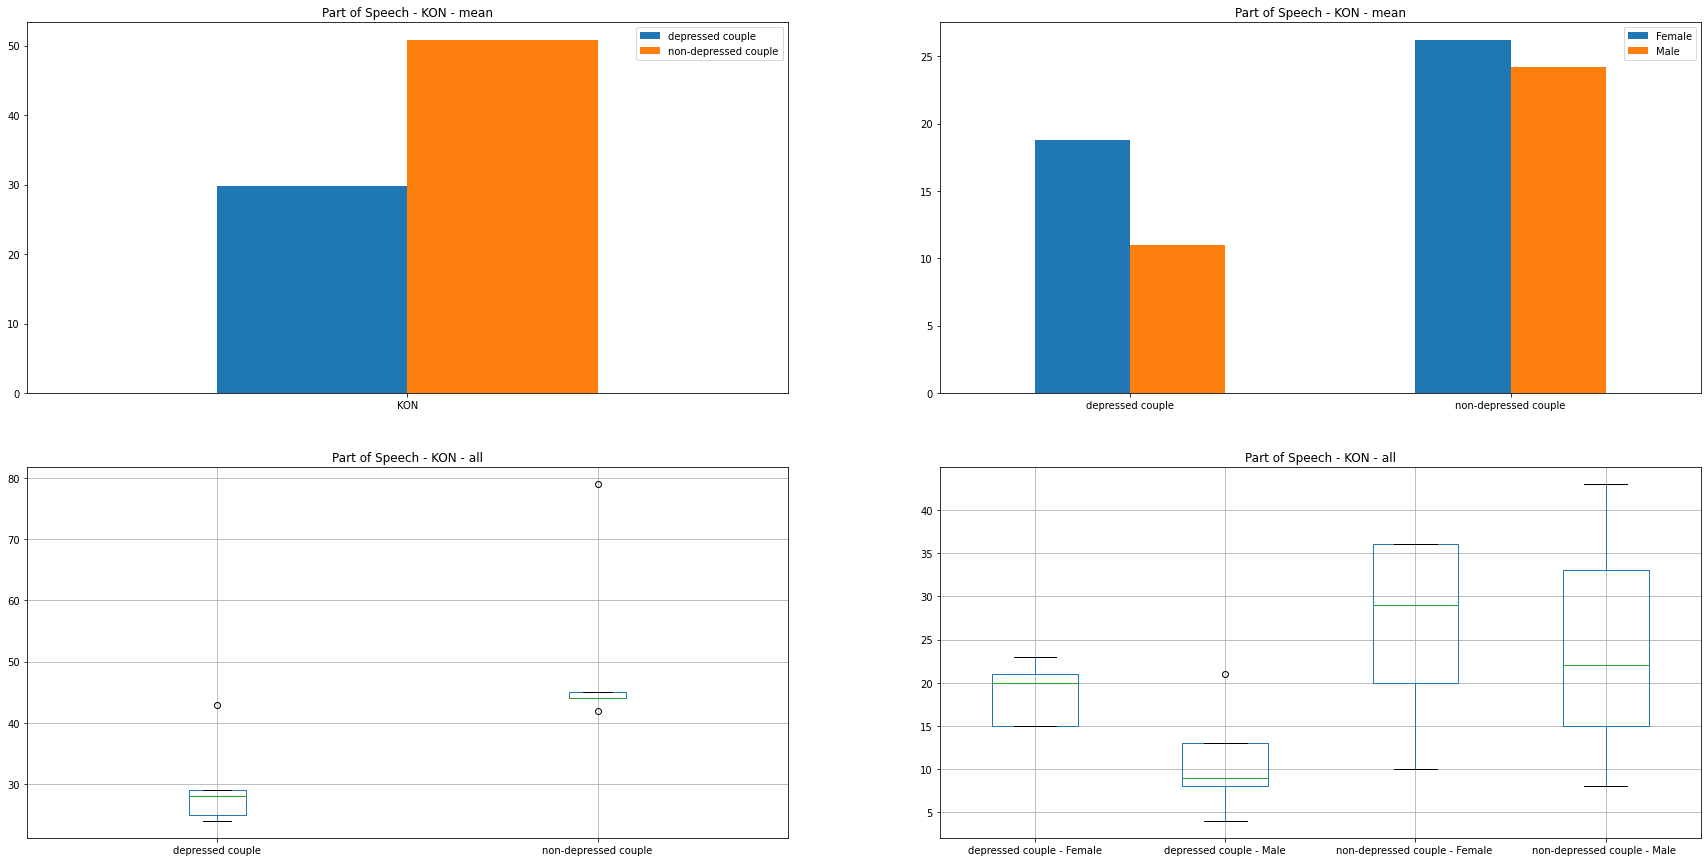

<Figure size 432x288 with 0 Axes>

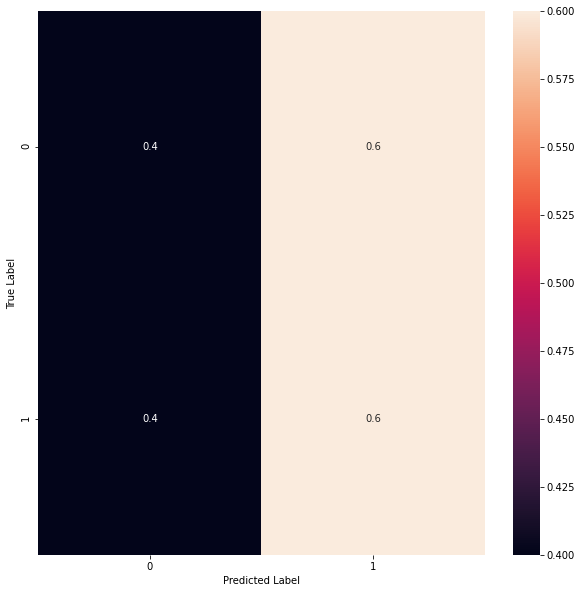

Executing NaiveBayes for [nb_class_tfidf(classifier), nb_class_liwc(classifier), nb_class_pos(classifier)]


,couple_id,is_depressed_group,nb_class_tfidf_predicted,nb_class_liwc_predicted,nb_class_pos_predicted
0,27,True,1,1,0
1,182,False,1,0,1
2,81,False,0,0,0
3,47,True,1,1,0
4,58,False,0,0,0
5,29,False,0,0,1
6,105,True,0,1,1
7,60,True,1,1,1
8,138,True,1,0,1
9,87,False,1,0,1


'----------------------------------------'

'Prediction from one cross-validation'

,couple_id,is_depressed_group,predicted
0,27,1,1
1,182,0,0
2,81,0,0
3,47,1,1
4,58,0,0
5,29,0,0
6,105,1,1
7,60,1,1
8,138,1,0
9,87,0,0


'Scores from 4 cross-validation(s)'

'----------------------------------------'

'Accuracy: [array([1. , 1. , 0.5, 1. , 1. ]), array([1. , 1. , 1. , 1. , 0.5]), array([0.5, 0.5, 1. , 1. , 1. ]), array([1. , 0.5, 0.5, 1. , 1. ])]'

'Mean of each: [0.9, 0.9, 0.8, 0.8] | Var of each: [0.04, 0.04, 0.06, 0.06]'

'Overall max: 0.9 | Overall mean: 0.8500000000000001 | Overall variance: 0.05'

'----------------------------------------'

'F1-score: [0.888888888888889, 0.888888888888889, 0.888888888888889, 0.888888888888889]'

'Mean of each: [0.888888888888889, 0.888888888888889, 0.888888888888889, 0.888888888888889] | Var of each: [0.0, 0.0, 0.0, 0.0]'

'Overall max: 0.888888888888889 | Overall mean: 0.888888888888889 | Overall variance: 0.0'

'----------------------------------------'

,couple_id,is_depressed_group,predicted
0,27,1,1
1,182,0,0
2,81,0,0
3,47,1,1
4,58,0,0
5,29,0,0
6,105,1,1
7,60,1,1
8,138,1,0
9,87,0,0


<Figure size 432x288 with 0 Axes>

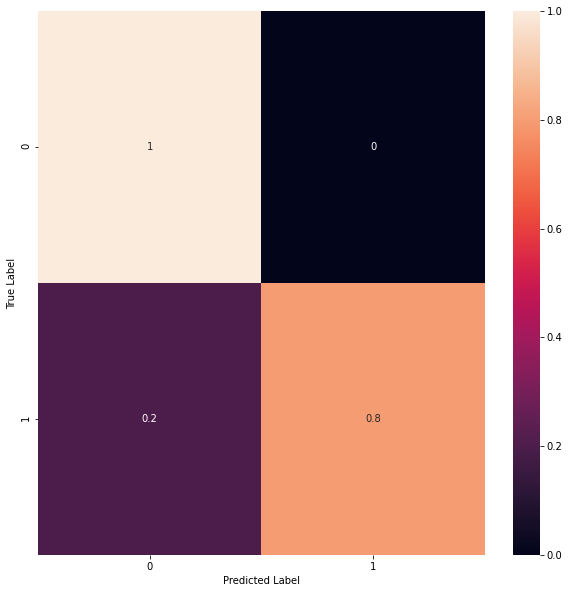

=== Finished pipeline execution ===


In [28]:
# Initialize pipeline
pipeline = Pipeline(queryable=queryable)

# Add preprocessing components 
pipeline.add_components([Tokenizer(), Stemmer(), Lemmatizer()])

# Add tfidf and tfidf-classifier 
pipeline.add_component(FeatureTFIDF(white_list=[
    'ja', 'auch', 'wenn', 'also', 'werden', 'schon', 'wir', 'und', 'haben', 'du', 'sehr'])),
pipeline.add_component(NaiveBayes(inputs=[TFIDF_DOCUMENT_MF], output=CLASSIFICATION_NAIVE_BAYES_TFIDF, cross_validate=True, voting=False, number_cross_validations=4))

# Add liwc and liwc-classifier 
pipeline.add_component(Liwc(white_list=[
    'Posemo', 'Past', 'Present', 'Future', 'Metaph','Death', 'Affect', 'Incl', 'Achieve'
]))
pipeline.add_component(NaiveBayes(inputs=[LIWC_DOCUMENT_MF], output=CLASSIFICATION_NAIVE_BAYES_LIWC, voting=False, cross_validate=True , number_cross_validations=4))

# Add pos and pos-classifier
pipeline.add_component(PartOfSpeech(white_list=["ADV", "PPER", "ADJD", "VAFIN", "KON"]))
pipeline.add_component(NaiveBayes(inputs=[POS_DOCUMENT_MF], output=CLASSIFICATION_NAIVE_BAYES_POS, voting=False, cross_validate=True, number_cross_validations=4))

# Classify with voting-classifier
pipeline.add_component(NaiveBayes(inputs=[
    CLASSIFICATION_NAIVE_BAYES_TFIDF, 
    CLASSIFICATION_NAIVE_BAYES_LIWC, 
    CLASSIFICATION_NAIVE_BAYES_POS,
], output=CLASSIFICATION_NAIVE_BAYES_VOTING, voting=True, cross_validate=True, number_cross_validations=4))

# Print results
storage = pipeline.execute(visualise=True)

# Pipeline with single Classifier

In [26]:
# Initialize pipeline
pipeline = Pipeline(queryable=queryable)

# Add preprocessing components 
pipeline.add_components([Tokenizer(), Stemmer(), Lemmatizer()])

# Add tfidf  
pipeline.add_component(FeatureTFIDF(white_list=[
    'ja', 'auch', 'wenn', 'also', 'werden', 'schon', 'wir', 'und', 'haben', 'du', 'sehr'])),

# Add liwc 
pipeline.add_component(Liwc(white_list=[
    'Posemo', 'Past', 'Present', 'Future', 'Metaph','Death', 'Affect', 'Incl', 'Achieve'
]))

# Add pos 
pipeline.add_component(PartOfSpeech(white_list=["ADV", "PPER", "ADJD", "VAFIN", "KON"]))

# Aggregate features 
pipeline.add_component(FeatureMerger())

# Classify 
pipeline.add_component(NaiveBayes())

# Print results
storage = pipeline.execute(visualise=True)

=== Starting pipeline with ['Tokenizer', 'Stemmer', 'Lemmatizer', 'FeatureTFIDF', 'Liwc', 'PartOfSpeech', 'FeatureMerger', 'NaiveBayes for [feature_vector(feature)]'] ===
Executing Tokenizer
Executing Stemmer
Executing Lemmatizer
Executing FeatureTFIDF
Executing Liwc
Executing PartOfSpeech
Executing FeatureMerger
Executing NaiveBayes for [feature_vector(feature)]


,couple_id,is_depressed_group,tfidf_document_mf_ja,tfidf_document_mf_auch,tfidf_document_mf_wenn,tfidf_document_mf_also,tfidf_document_mf_werden,tfidf_document_mf_schon,tfidf_document_mf_wir,tfidf_document_mf_und,...,pos_sentence_f_PPER,pos_sentence_f_ADJD,pos_sentence_f_VAFIN,pos_sentence_f_KON,document_id_y,pos_sentence_m_ADV,pos_sentence_m_PPER,pos_sentence_m_ADJD,pos_sentence_m_VAFIN,pos_sentence_m_KON
0,27,True,0.285468,0.190312,0.158593,0.023789,0.047578,0.000000,0.174453,0.174453,...,1.648148,0.759259,0.555556,0.388889,0,1.458333,1.729167,0.666667,0.645833,0.187500
1,47,True,0.381989,0.238743,0.083560,0.071623,0.023874,0.026150,0.131309,0.202931,...,1.727273,0.848485,0.424242,0.484848,3,0.846154,0.717949,0.641026,0.487179,0.230769
2,58,False,0.107947,0.165519,0.028786,0.007196,0.043179,0.031529,0.158322,0.230287,...,1.965517,0.827586,0.689655,0.724138,4,2.755556,2.244444,1.266667,1.111111,0.555556
3,29,False,0.254254,0.095345,0.038138,0.076276,0.031782,0.069622,0.044494,0.228828,...,2.500000,0.942308,1.403846,0.730769,5,1.206897,1.068966,0.620690,0.517241,0.275862
4,60,True,0.246445,0.164297,0.116377,0.027383,0.088994,0.157461,0.082148,0.150605,...,1.358974,0.666667,0.589744,0.333333,7,1.320755,0.792453,0.339623,0.452830,0.113208


ValueError: n_splits=5 cannot be greater than the number of members in each class.